In this study, the ESIF VASP Benchmark 2 (https://github.com/NREL/ESIFHPC3/tree/master/VASP/bench2) was used to study how the cpu-bind flag affects the way that tasks are assigned to cores throughout the node over the runtime of a VASP job on Swfit and Eagle. Benchmark 1 is a system of 16 atoms (Cu4In4Se8), and Benchmark 2 is a system of 519 atoms (Ag504C4H10S1).

On Swift, the default builds of VASP installed on the system as modules were used. The Intel MPI build was built with Intel compilers and the mkl math library, and it was accessed via the "vaspintel" module. The OpenMPI build was compiled with gnu using gcc and fortran compilers and used OpenMPI's math libraries, and was accessed via the "vasp" module. Both builds run VASP 6.1.1.

On Eagle, the default build of VASP installed on the system is an Intel MPI version of VASP. The Intel MPI build was built with Intel compilers and the mkl math library, and it was accessed via the "vasp" module. It runs VASP 6.1.2. No Open MPI VASP build is accessible through the default modules on Eagle, but an Open MPI build can be accessed in an environment via "source /nopt/nrel/apps/210830a/myenv.2108301742, ml vasp/6.1.1-l2mkbb2". The OpenMPI build was compiled with gnu using gcc and fortran compilers and used OpenMPI's math libraries. It runs VASP 6.1.1.

The VASP repo (https://github.com/claralarson/HPC/tree/master/applications/vasp/VASP%20Recommendations) contains scripts that can be used to run the Intel MPI and Open MPI builds used in the study to perform calculations on Swift and Eagle.

## Table of Contents

* [Swift](#Swift)
    * [Summary of Swift cpu-bind Results](#Summary-of-Swift-cpu-bind-Results)
    * [Plot CPU Usage Over Time for Each Virtual Core](#Plot-CPU-Usage-Over-Time-for-Each-Virtual-Core)
    * [Plot CPU Usage Over Time for Each Physical Core](#Plot-CPU-Usage-Over-Time-for-Each-Physical-Core-(virtual-cores-combined))
    * [Analyze Thread Assignment to Virtual Cores](#Re-Format-Swift-Data-to-Analyze-Thread-Assignment-to-Virtual-Cores)
    * [Analyze Thread Assignment to Physical Cores](#Re-Format-Swift-Data-to-Analyze-Thread-Assignment-to-Physical-Cores)
* [Eagle](#Eagle)
    * [Summary of Swift cpu-bind Results](#Summary-of-Swift-cpu-bind-Results)
    * [Plot CPU Usage Over Time for Each Core](#Plot-CPU-Usage-Over-Time-for-Each-Core)
    * [Analyze Thread Assignment to Cores](#Analyze-Thread-Assignment-to-Cores)

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Swift

On Swift, calculations requested full nodes (64 cores/node). This was set using "--tasks-per-node=64 -n 64*[num nodes]".

### Read Files

In [31]:
swift_dir = "swift_onnodes_data"

swift_onnodes = [f for f in listdir(swift_dir) if (".ipynb" not in f)]

In [3]:
swift_onnodes

['openmpi_4_none',
 'openmpi_4_rank',
 'intel_1_cores',
 'intel_4_cores',
 'intel_1_none',
 'intel_1_rank',
 'openmpi_2_none',
 'intel_2_cores',
 'openmpi_2_rank',
 'intel_2_none',
 'intel_2_rank',
 'openmpi_1_none',
 'openmpi_1_rank',
 'openmpi_2_cores',
 'openmpi_4_cores',
 'intel_4_none',
 'intel_4_rank',
 'openmpi_1_cores']

### Summary of Swift cpu-bind Results

On Swift, each node has 64 physical cores, and each core is subdivided into two virtual cores in a processes that is identical to hyperthreading. Because of this, up 128 cores can be requested from a single Swift node, but each core will only represent half of a physical core. In the plots in the [Plot CPU Usage Over Time for Each Virtual Core)](#Plot-CPU-Usage-Over-Time-for-Each-Virtual-Core) section, the "Distinct Cores" axis represnets distinct virtual cores, that is, each integer represents half of a physical core. For 128 cores in a node, cores 1-64 represent half of each physical core, and 65-128 represent the other half of the corresponding physical core. In the [Plot CPU Usage Over Time for Each Physical Core)](#Plot-CPU-Usage-Over-Time-for-Each-Physical-Core-(virtual-cores-combined)) section, we combine the data for the two halves of a physical core to see the usage over an entire physical core, rather than than the usage over halves of physical cores. We find that the CPU usage is evenly distributed across physical cores over time, although the graphs in the section above tell us that the CPU usage jumps back and forth between both sides of the physical core over time for cpu-bind=cores and no cpu-bind. In the [Plot CPU Usage Over Time for Each Virtual Core)](#Plot-CPU-Usage-Over-Time-for-Each-Virtual-Core) section, we see that setting cpu-bind=rank contains the CPU usage to one half of the physical node, and so it is expected that the graphs below show consistent usage across all CPUs over time for cpu-bind=rank.

### Plot CPU Usage Over Time for Each Virtual Core

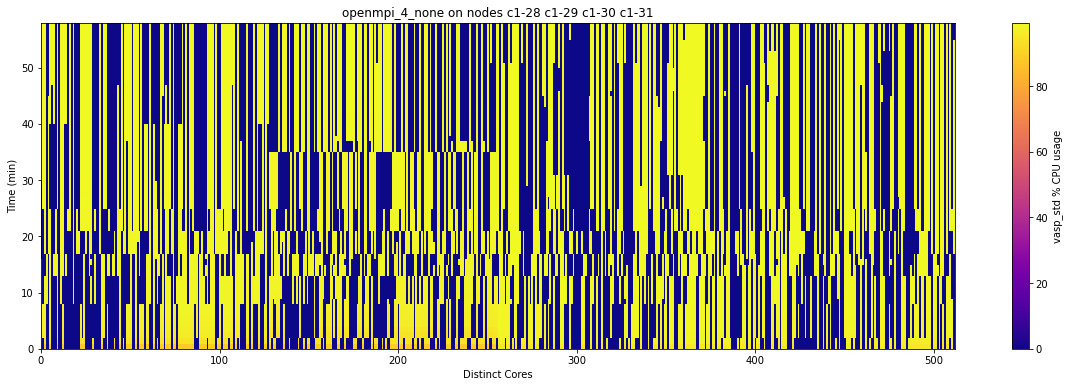

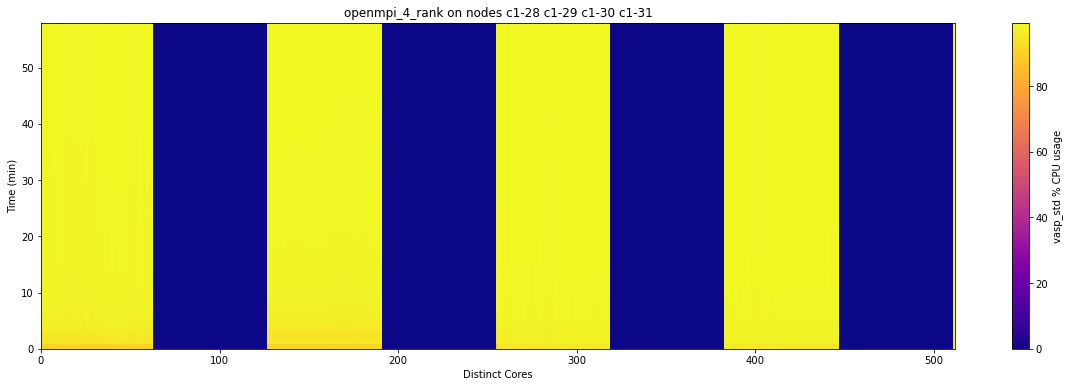

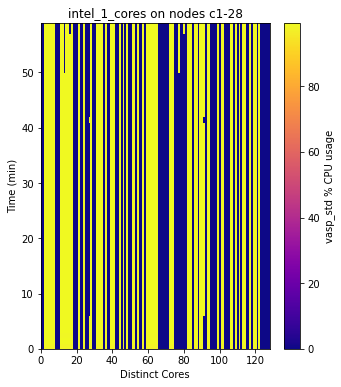

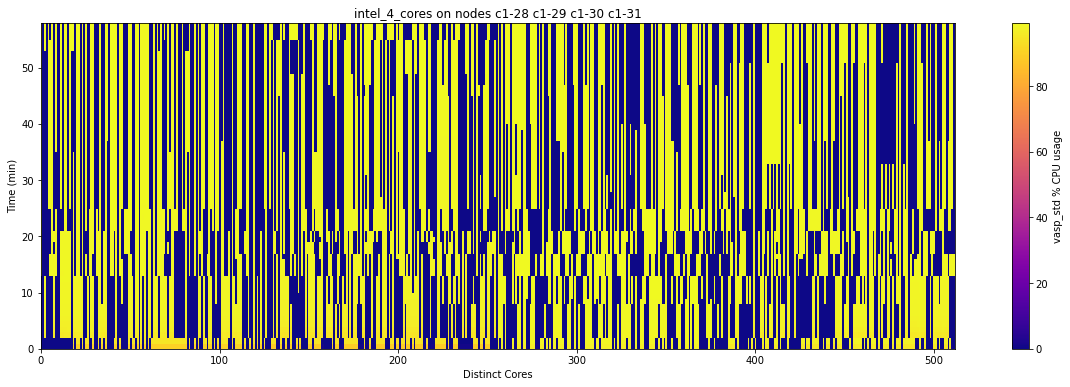

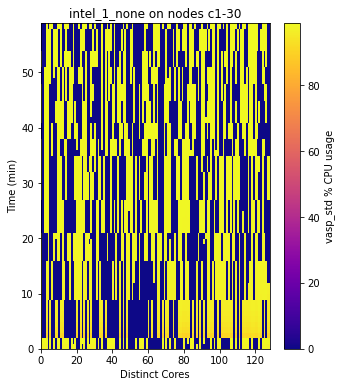

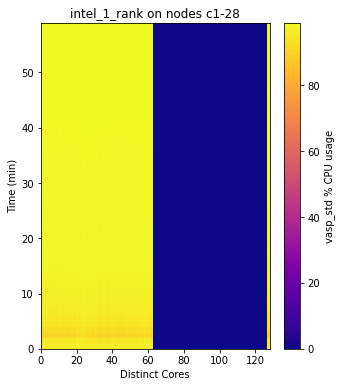

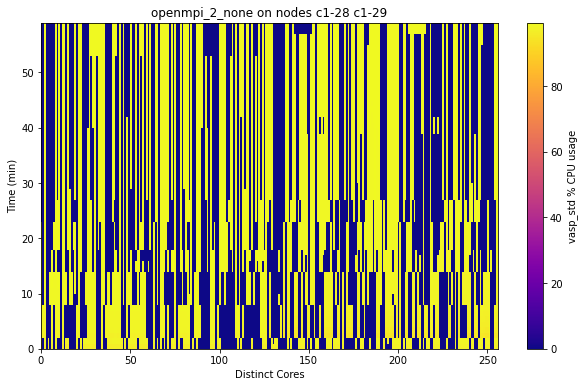

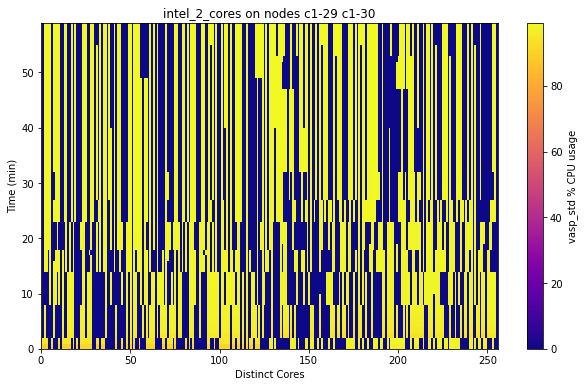

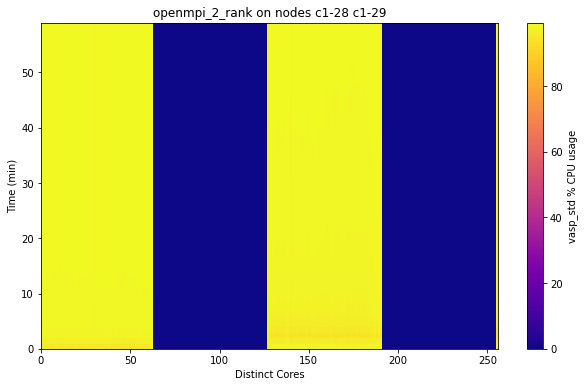

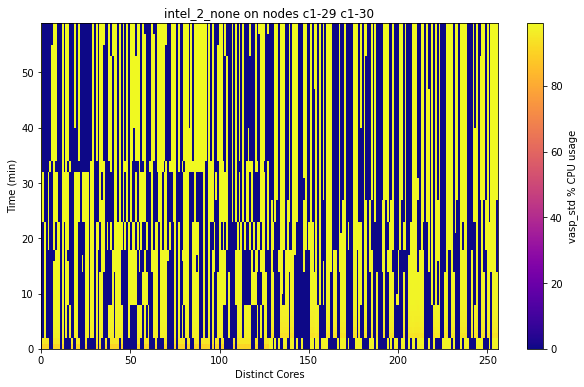

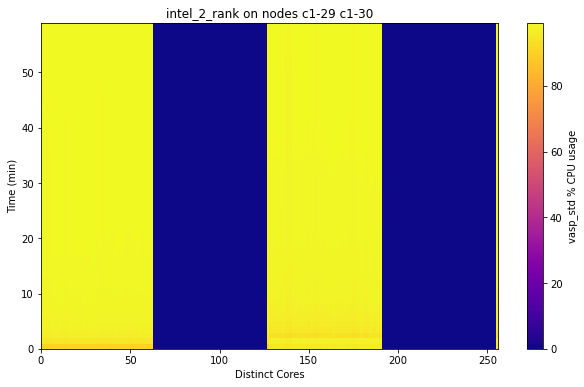

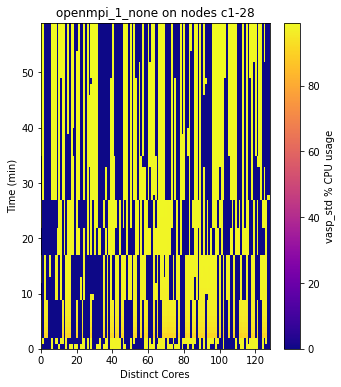

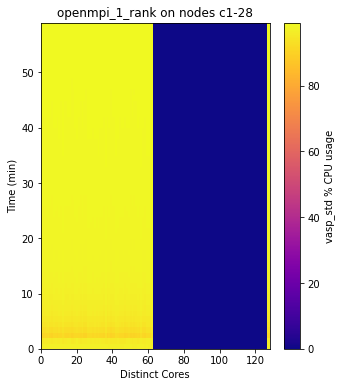

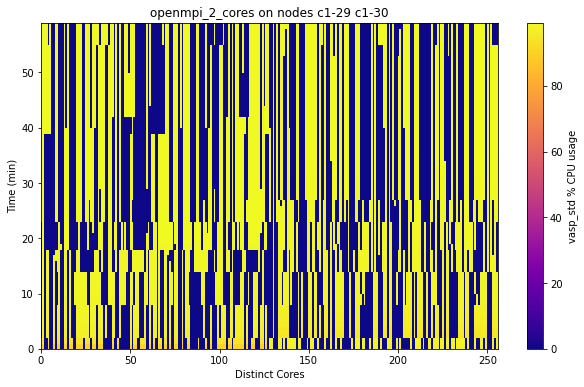

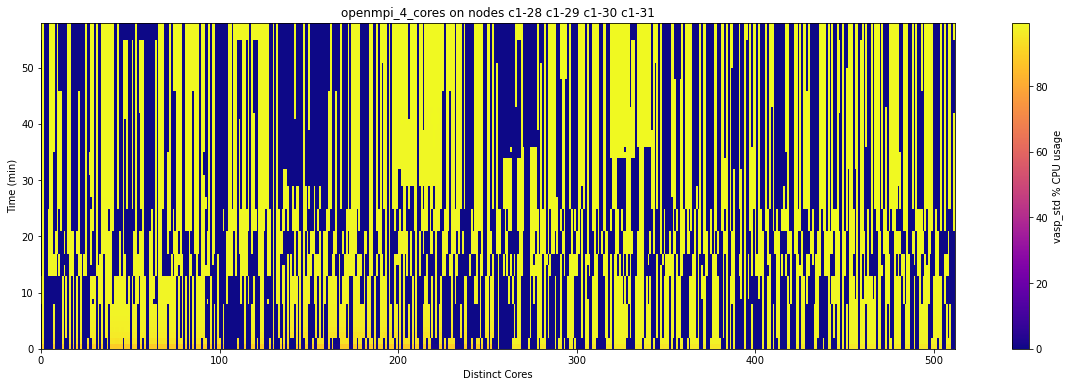

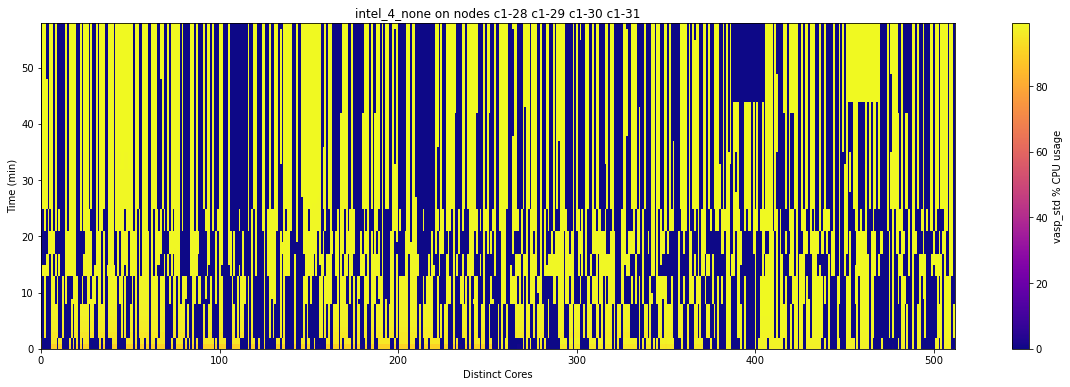

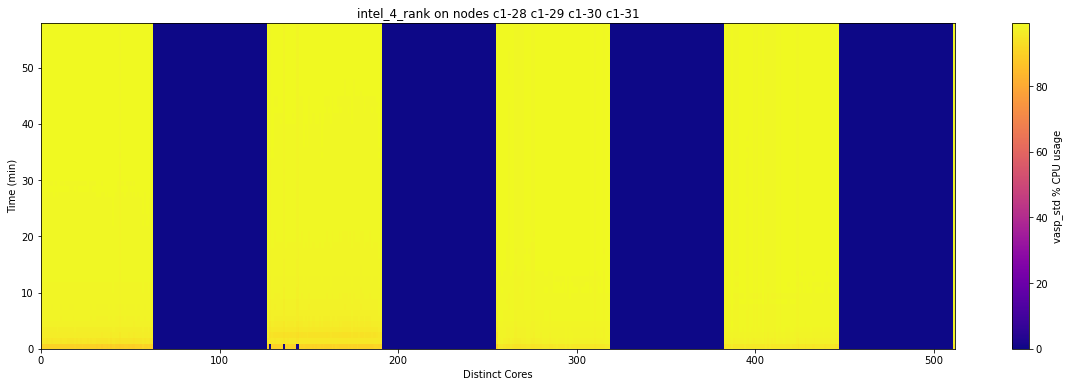

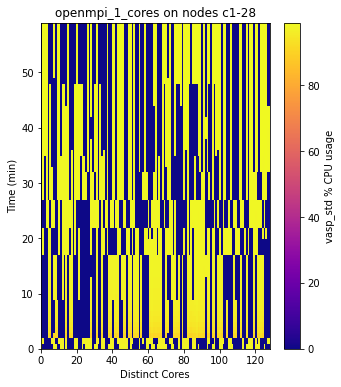

In [4]:
for file in swift_onnodes:
    f = open("swift/"+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()[-5:]
    for i in range(1, len(data)):
        if "c1-" in data[i]:
            data_array.append(one_run)
            node = data[i].strip()[-5:]
            one_run = []
        else:   
            array_line = np.array(data[i].split())
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[4]),node]
                        one_run.append(info)
    data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(128)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    locals()["swift_"+file] = all_data
    fig = plt.figure(figsize=(8*(len(all_data[0])/200),6))
    plot = plt.pcolormesh(all_data,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("vasp_std % CPU usage")
    title = file + " on nodes"
    for node in nodes:
        title += " "
        title += node
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

### Plot CPU Usage Over Time for Each Physical Core (virtual cores combined)

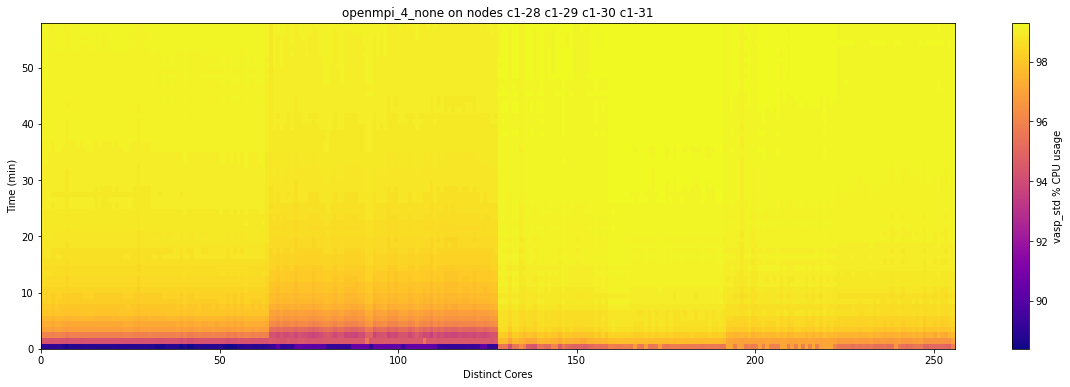

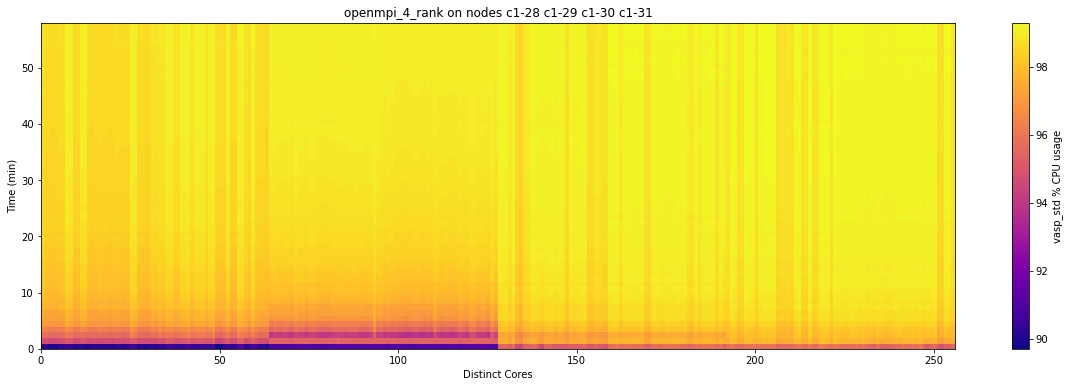

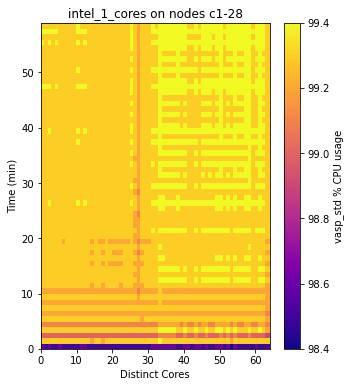

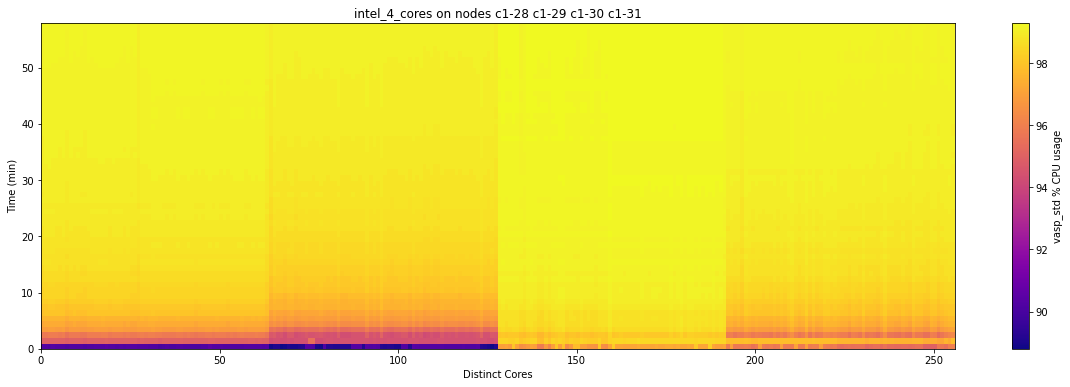

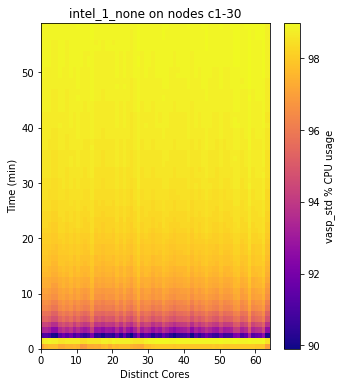

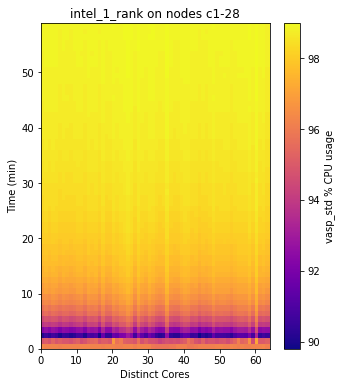

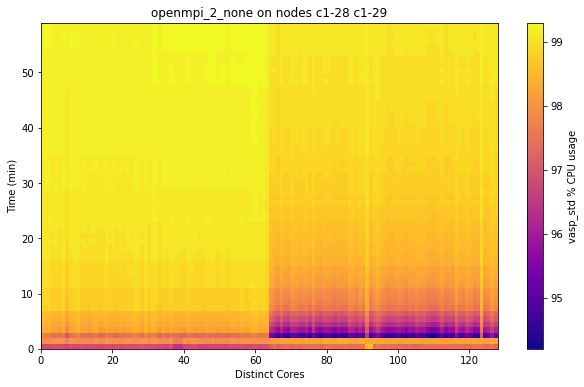

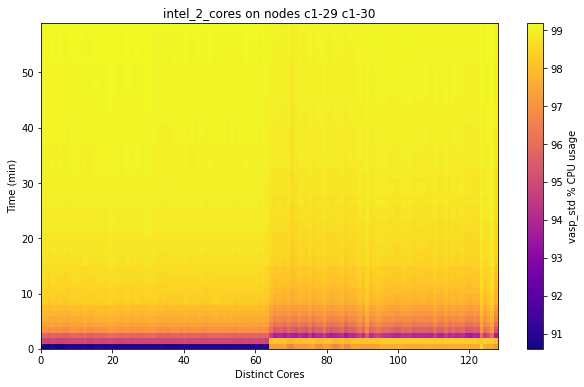

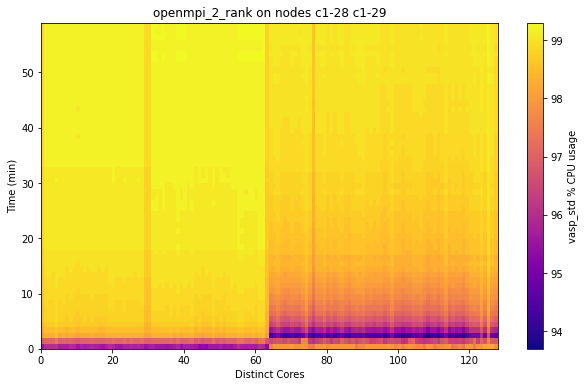

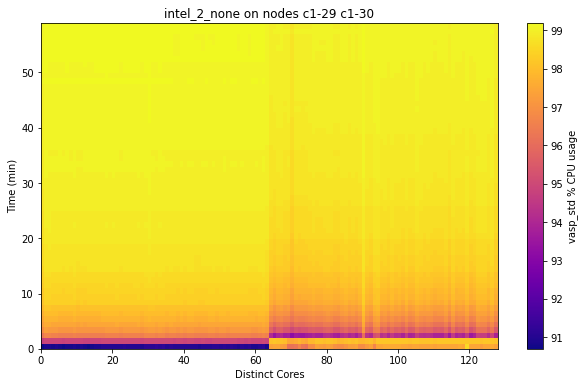

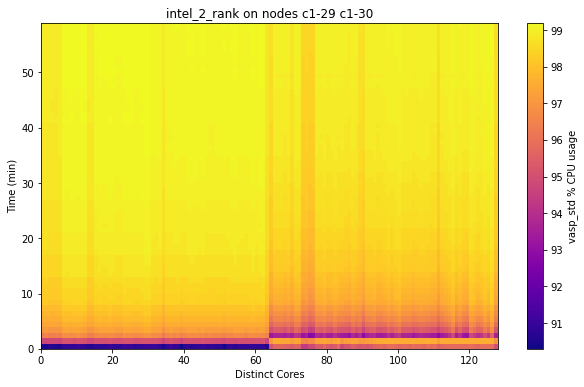

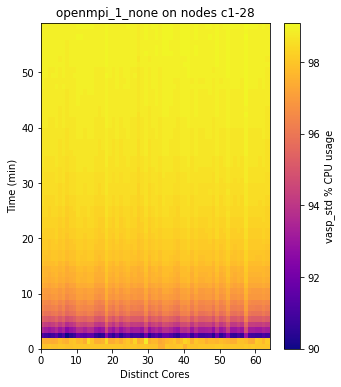

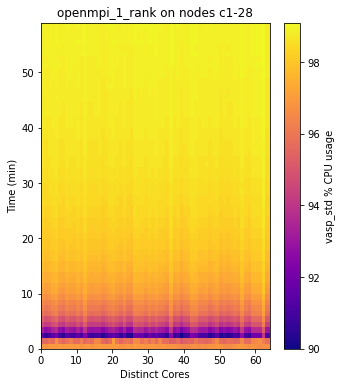

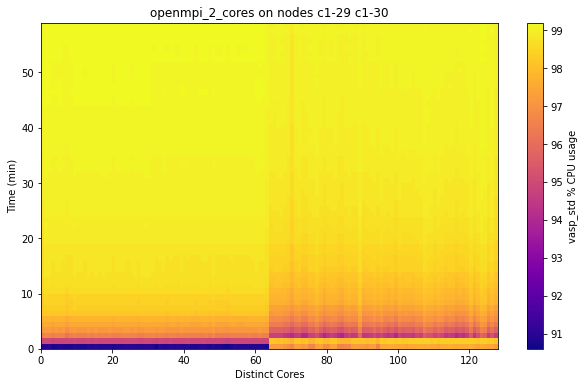

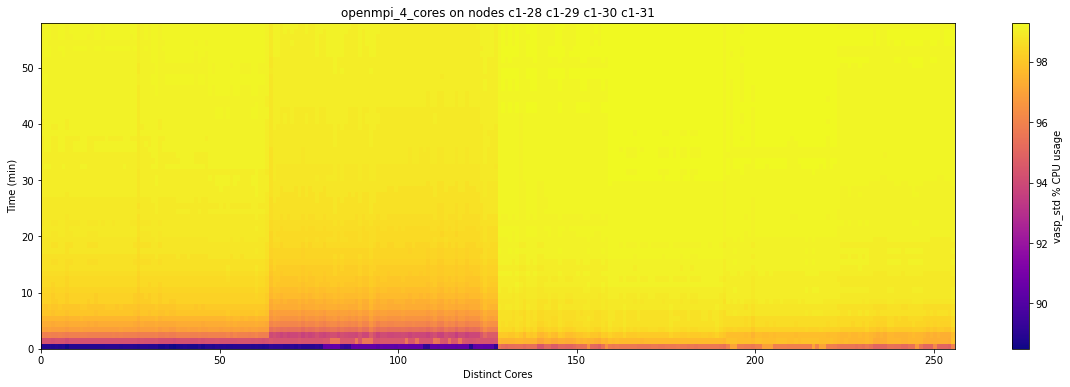

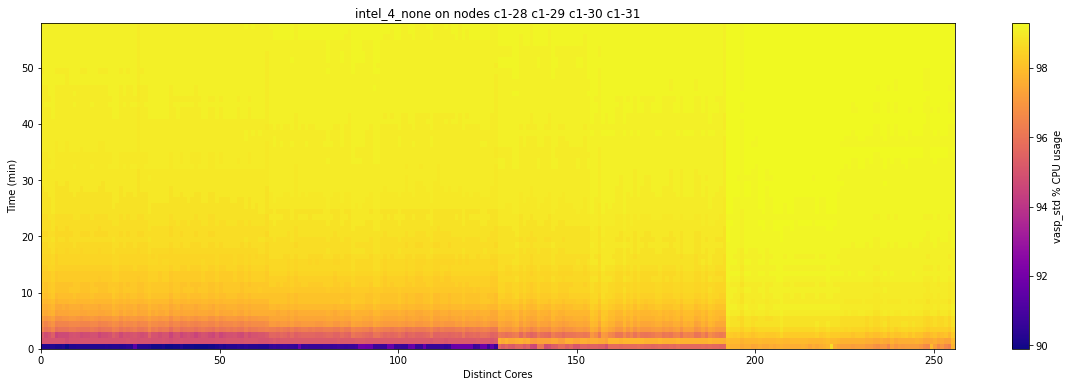

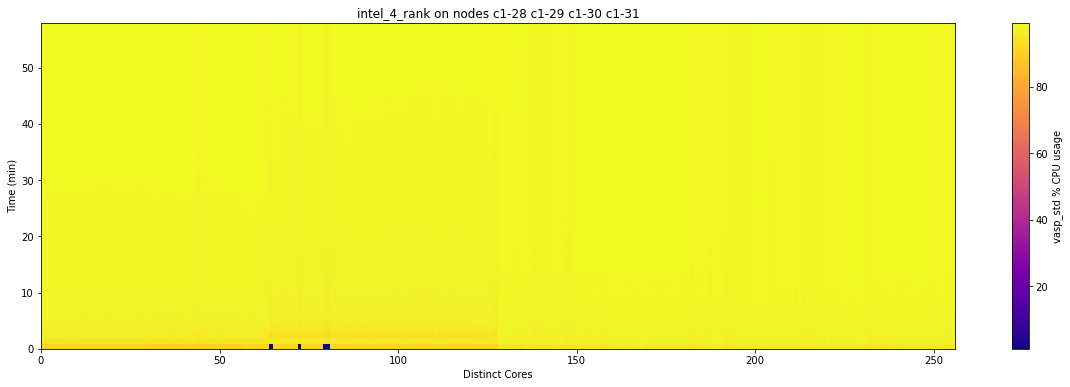

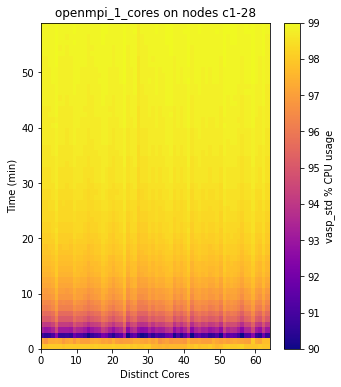

In [5]:
for file in swift_onnodes:
    f = open("swift/"+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()[-5:]
    for i in range(1, len(data)):
        if "c1-" in data[i]:
            data_array.append(one_run)
            node = data[i].strip()[-5:]
            one_run = []
        else:   
            array_line = np.array(data[i].split())
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[4]),node]
                        one_run.append(info)
    data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(128)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    all_data_phys_cores = []
    for row in all_data:
        new_row = []
        for index, i in enumerate(row):
            divisor = int(index)//64
            if divisor%2==0:
                new_row.append(i)
            else:
                new_row[int(index-64*(divisor+1)/2)]+=i
        all_data_phys_cores.append(new_row)
    locals()["swift_"+file+"_phys"] = all_data_phys_cores
    fig = plt.figure(figsize=(8*(len(all_data_phys_cores[0])/100),6))
    plot = plt.pcolormesh(all_data_phys_cores,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("vasp_std % CPU usage")
    title = file + " on nodes"
    for node in nodes:
        title += " "
        title += node
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

### Analyze Thread Assignment to Virtual Cores

openmpi_4_none on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [    0. 92791.]
1 [    0. 92793.]
2 [    0. 92795.]
3 [    0. 92797.]
4 [    0. 92799.]
5 [    0. 92801.]
6 [    0. 92803.]
7 [    0. 92805.]
8 [    0. 92807.]
9 [    0. 92809.]
10 [0.]
11 [    0. 92813.]
12 [    0. 92815.]
13 [    0. 92817.]
14 [    0. 92819.]
15 [    0. 92821.]
16 [    0. 92823.]
17 [0.]
18 [    0. 92827.]
19 [0.]
20 [    0. 92831.]
21 [    0. 92833.]
22 [    0. 92835.]
23 [    0. 92837.]
24 [    0. 92839.]
25 [    0. 92841.]
26 [    0. 92843.]
27 [    0. 92845.]
28 [    0. 92847.]
29 [    0. 92849.]
30 [    0. 92851.]
31 [0.]
32 [0.]
33 [    0. 92794.]
34 [    0. 92796.]
35 [    0. 92798.]
36 [    0. 92800.]
37 [    0. 92802.]
38 [    0. 92804.]
39 [0.]
40 [    0. 92808.]
41 [    0. 92810.]
42 [0.]
43 [    0. 92814.]
44 [    0. 92816.]
45 [    0. 92818.]
46 [    0. 92820.]
47 [    0. 92822.]
48 [    0. 92824.]
49 [    0. 92826.]
50 [92828.]
51 [    0. 92830.]
52 [    0. 92

471 [     0. 707668.]
472 [     0. 707670.]
473 [0.]
474 [     0. 707950.]
475 [     0. 707676.]
476 [     0. 707678.]
477 [     0. 707680. 708083.]
478 [     0. 707682.]
479 [0.]
480 [     0. 707623.]
481 [     0. 707625.]
482 [707627.]
483 [     0. 707629.]
484 [     0. 707631.]
485 [0.]
486 [     0. 707635.]
487 [     0. 707637.]
488 [     0. 707639.]
489 [     0. 707641.]
490 [     0. 707643.]
491 [     0. 707645.]
492 [     0. 707647.]
493 [     0. 707649.]
494 [     0. 707651.]
495 [     0. 707653.]
496 [707655.]
497 [     0. 707657.]
498 [     0. 707659.]
499 [     0. 707661.]
500 [     0. 707663.]
501 [707665.]
502 [     0. 707667.]
503 [     0. 707669.]
504 [     0. 707671.]
505 [     0. 707673.]
506 [0.]
507 [     0. 707677.]
508 [     0. 707679.]
509 [     0. 707681.]
510 [     0. 707683.]
511 [     0. 707620.]
Threads running on multiple cores (Thread ID, number of cores processed on)
92789.0 2
92791.0 2
92793.0 2
92794.0 2
92795.0 2
92796.0 2
92797.0 2
92798.0 2
92799.0 2


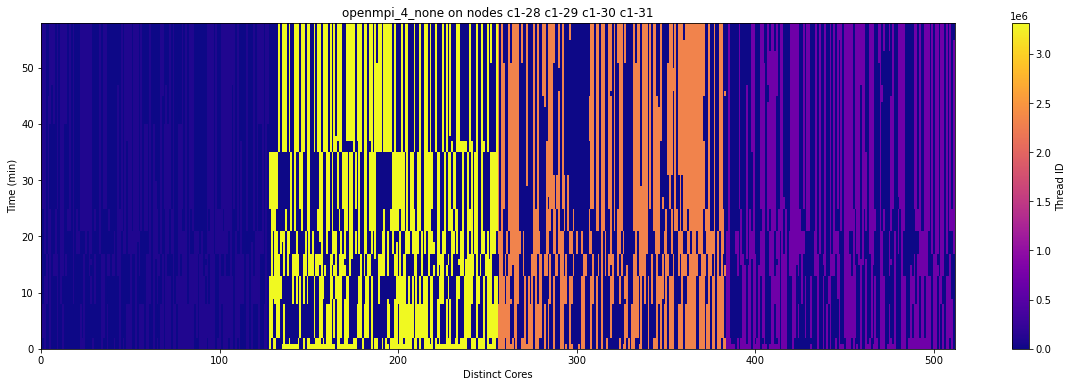

openmpi_4_rank on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [98451.]
1 [98452.]
2 [98453.]
3 [98454.]
4 [98455.]
5 [98456.]
6 [98457.]
7 [98458.]
8 [98459.]
9 [98460.]
10 [98461.]
11 [98462.]
12 [98463.]
13 [98464.]
14 [98465.]
15 [98466.]
16 [98467.]
17 [98468.]
18 [98469.]
19 [98470.]
20 [98471.]
21 [98472.]
22 [98473.]
23 [98474.]
24 [98475.]
25 [98476.]
26 [98477.]
27 [98478.]
28 [98479.]
29 [98480.]
30 [98481.]
31 [98482.]
32 [98483.]
33 [98484.]
34 [98485.]
35 [98486.]
36 [98487.]
37 [98488.]
38 [98489.]
39 [98490.]
40 [98491.]
41 [98492.]
42 [98493.]
43 [98494.]
44 [98495.]
45 [98496.]
46 [98497.]
47 [98498.]
48 [98499.]
49 [98500.]
50 [98501.]
51 [98502.]
52 [98503.]
53 [98504.]
54 [98505.]
55 [98506.]
56 [98507.]
57 [98508.]
58 [98509.]
59 [98510.]
60 [98511.]
61 [98512.]
62 [98513.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [0.]
73 [0.]
74 [0.]
75 [0.]
76 [0.]
77 [0.]
78 [0.]
79 [0.]
80 [0.]
81 [0.]
82 [0.]
8

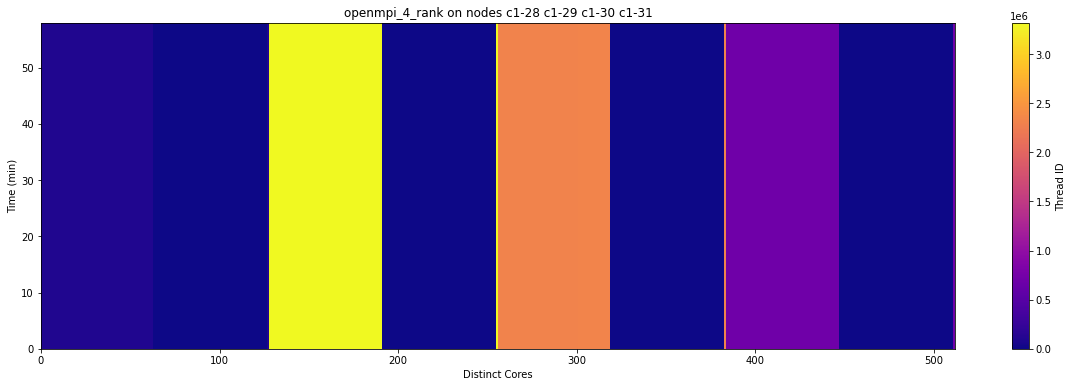

intel_1_cores on nodes c1-28
Threads running (by Thread ID) on each core:
0 [0.]
1 [0.]
2 [65756.]
3 [65758.]
4 [65760.]
5 [65762.]
6 [65764.]
7 [65766.]
8 [0.]
9 [0.]
10 [0.]
11 [65774.]
12 [65776.]
13 [    0. 65778.]
14 [65780.]
15 [65782.]
16 [    0. 65784.]
17 [65786.]
18 [0.]
19 [0.]
20 [0.]
21 [65794.]
22 [0.]
23 [0.]
24 [65800.]
25 [0.]
26 [0.]
27 [    0. 65806.]
28 [65808.]
29 [0.]
30 [0.]
31 [65751.]
32 [65753.]
33 [65755.]
34 [65757.]
35 [0.]
36 [65761.]
37 [0.]
38 [0.]
39 [65767.]
40 [65769.]
41 [65771.]
42 [0.]
43 [0.]
44 [65777.]
45 [0.]
46 [65781.]
47 [0.]
48 [65785.]
49 [0.]
50 [0.]
51 [65791.]
52 [65793.]
53 [0.]
54 [65797.]
55 [0.]
56 [0.]
57 [65803.]
58 [0.]
59 [65807.]
60 [65809.]
61 [65811.]
62 [65813.]
63 [65750.]
64 [65752.]
65 [65754.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [65768.]
73 [65770.]
74 [65772.]
75 [0.]
76 [0.]
77 [    0. 65778.]
78 [0.]
79 [0.]
80 [    0. 65784.]
81 [0.]
82 [65788.]
83 [65790.]
84 [65792.]
85 [0.]
86 [65796.]
87 [65798.]
8

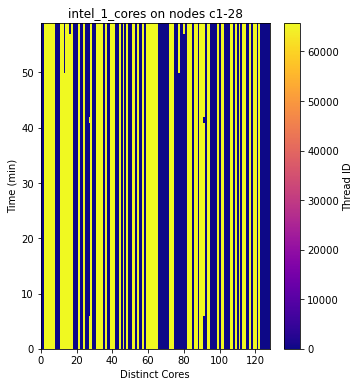

intel_4_cores on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [    0. 70090.]
1 [0.]
2 [    0. 70094.]
3 [0.]
4 [    0. 70098.]
5 [    0. 70100.]
6 [    0. 70102.]
7 [    0. 70104.]
8 [    0. 70106.]
9 [0.]
10 [0.]
11 [    0. 70112.]
12 [    0. 70114.]
13 [    0. 70116.]
14 [    0. 70118.]
15 [    0. 70120.]
16 [    0. 70122.]
17 [    0. 70124.]
18 [    0. 70126.]
19 [    0. 70128.]
20 [70130.]
21 [70132.]
22 [    0. 70134.]
23 [70136.]
24 [0.]
25 [    0. 70140.]
26 [    0. 70142.]
27 [    0. 70144.]
28 [    0. 70146.]
29 [    0. 70148.]
30 [0.]
31 [    0. 70089.]
32 [    0. 70091.]
33 [    0. 70093.]
34 [    0. 70095.]
35 [    0. 70097.]
36 [70099.]
37 [    0. 70101.]
38 [0.]
39 [    0. 70105.]
40 [    0. 70107.]
41 [    0. 70109.]
42 [70111.]
43 [0.]
44 [    0. 70115.]
45 [    0. 70117.]
46 [0.]
47 [    0. 70121.]
48 [    0. 70123.]
49 [70125.]
50 [    0. 70127.]
51 [    0. 70129.]
52 [    0. 70131.]
53 [    0. 70133.]
54 [70135.]
55 [0.]
56 [70139.]
5

449 [     0. 697020. 697492.]
450 [     0. 697022.]
451 [     0. 697024.]
452 [     0. 697026.]
453 [     0. 697028.]
454 [     0. 697030.]
455 [     0. 697032.]
456 [     0. 697034.]
457 [     0. 697036.]
458 [     0. 697038.]
459 [     0. 697040.]
460 [     0. 697042.]
461 [     0. 697044.]
462 [     0. 697046.]
463 [     0. 697048.]
464 [     0. 697050.]
465 [697052.]
466 [     0. 697054.]
467 [     0. 697056.]
468 [0.]
469 [     0. 697060.]
470 [     0. 697062. 697478.]
471 [     0. 697064.]
472 [     0. 697066.]
473 [     0. 697068.]
474 [     0. 697070.]
475 [     0. 697072.]
476 [     0. 697074.]
477 [     0. 697076.]
478 [     0. 697078.]
479 [     0. 697017.]
480 [     0. 697019.]
481 [697021.]
482 [0.]
483 [     0. 697025.]
484 [     0. 697027.]
485 [697029.]
486 [     0. 697031.]
487 [     0. 697033.]
488 [     0. 697035.]
489 [     0. 697037.]
490 [     0. 697039.]
491 [     0. 697041.]
492 [697043.]
493 [     0. 697045.]
494 [     0. 697047.]
495 [     0. 697049.]
496 [   

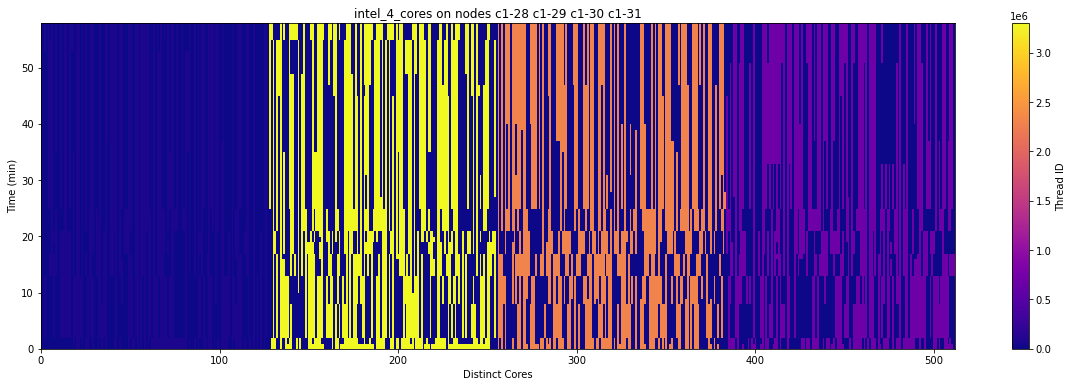

intel_1_none on nodes c1-30
Threads running (by Thread ID) on each core:
0 [      0. 2334957.]
1 [      0. 2334959.]
2 [      0. 2334961.]
3 [      0. 2334963.]
4 [      0. 2334965.]
5 [      0. 2334967.]
6 [      0. 2334969.]
7 [      0. 2334971.]
8 [      0. 2334973.]
9 [      0. 2334975.]
10 [      0. 2334977.]
11 [      0. 2334979.]
12 [      0. 2334981.]
13 [      0. 2334983.]
14 [      0. 2334985.]
15 [      0. 2334987.]
16 [      0. 2334989.]
17 [      0. 2334991.]
18 [      0. 2334993.]
19 [      0. 2334995.]
20 [      0. 2334997.]
21 [      0. 2334999.]
22 [      0. 2335001.]
23 [      0. 2335003.]
24 [      0. 2335005.]
25 [      0. 2335007.]
26 [      0. 2335009.]
27 [      0. 2335011.]
28 [      0. 2335013.]
29 [      0. 2335015.]
30 [      0. 2335017.]
31 [      0. 2334956.]
32 [      0. 2334958.]
33 [      0. 2334960.]
34 [      0. 2334962.]
35 [      0. 2334964.]
36 [      0. 2334966.]
37 [      0. 2334968.]
38 [      0. 2334970.]
39 [      0. 2334972.]
40 [      0. 2334

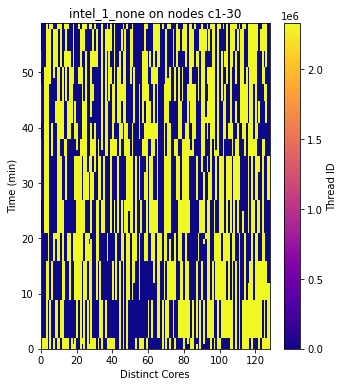

intel_1_rank on nodes c1-28
Threads running (by Thread ID) on each core:
0 [836920.]
1 [836921.]
2 [836922.]
3 [836923.]
4 [836924.]
5 [836925.]
6 [836926.]
7 [836927.]
8 [836928.]
9 [836929.]
10 [836930.]
11 [836931.]
12 [836932.]
13 [836933.]
14 [836934.]
15 [836935.]
16 [836936.]
17 [836937.]
18 [836938.]
19 [836939.]
20 [836940.]
21 [836941.]
22 [836942.]
23 [836943.]
24 [836944.]
25 [836945.]
26 [836946.]
27 [836947.]
28 [836948.]
29 [836949.]
30 [836950.]
31 [836951.]
32 [836952.]
33 [836953.]
34 [836954.]
35 [836955.]
36 [836956.]
37 [836957.]
38 [836958.]
39 [836959.]
40 [836960.]
41 [836961.]
42 [836962.]
43 [836963.]
44 [836964.]
45 [836965.]
46 [836966.]
47 [836967.]
48 [836968.]
49 [836969.]
50 [836970.]
51 [836971.]
52 [836972.]
53 [836973.]
54 [836974.]
55 [836975.]
56 [836976.]
57 [836977.]
58 [836978.]
59 [836979.]
60 [836980.]
61 [836981.]
62 [836982.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [0.]
73 [0.]
74 [0.]
75 [0.]
76 [0.]
77 [0.

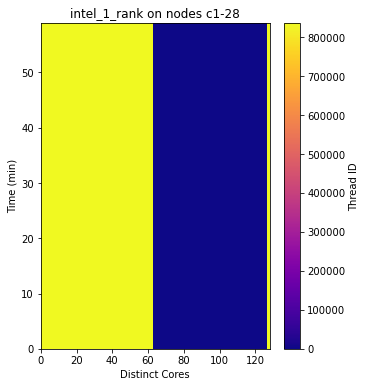

openmpi_2_none on nodes c1-28 c1-29
Threads running (by Thread ID) on each core:
0 [     0. 824906.]
1 [     0. 824908.]
2 [824910.]
3 [0.]
4 [     0. 824914.]
5 [     0. 824916.]
6 [     0. 824918.]
7 [     0. 824920.]
8 [824922.]
9 [     0. 824924.]
10 [     0. 824926.]
11 [0.]
12 [824930.]
13 [     0. 824932.]
14 [     0. 824934.]
15 [     0. 824936.]
16 [     0. 824938.]
17 [     0. 824940.]
18 [     0. 824942.]
19 [     0. 824944.]
20 [     0. 824946.]
21 [     0. 824948.]
22 [     0. 824950.]
23 [0.]
24 [     0. 824954.]
25 [     0. 824956.]
26 [     0. 824958.]
27 [824960.]
28 [     0. 824962.]
29 [     0. 824964.]
30 [824966.]
31 [     0. 824905.]
32 [     0. 824907.]
33 [     0. 824909.]
34 [824911.]
35 [     0. 824913.]
36 [     0. 824915.]
37 [     0. 824917.]
38 [     0. 824919.]
39 [     0. 824921.]
40 [     0. 824923.]
41 [     0. 824925.]
42 [     0. 824927.]
43 [     0. 824929.]
44 [824931.]
45 [     0. 824933.]
46 [     0. 824935.]
47 [     0. 824937.]
48 [     0. 8249

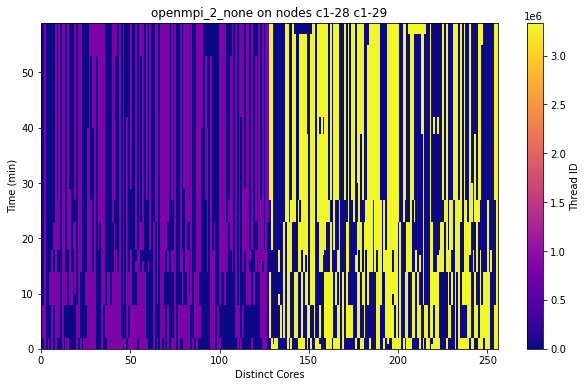

intel_2_cores on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [3321538.]
1 [      0. 3321540.]
2 [      0. 3321542.]
3 [      0. 3321544.]
4 [      0. 3321546.]
5 [      0. 3321548.]
6 [      0. 3321550.]
7 [      0. 3321552.]
8 [      0. 3321554.]
9 [      0. 3321556.]
10 [      0. 3321558.]
11 [0.]
12 [      0. 3321562.]
13 [      0. 3321564.]
14 [      0. 3321566.]
15 [      0. 3321568.]
16 [      0. 3321570.]
17 [      0. 3321572.]
18 [      0. 3321574.]
19 [      0. 3321576.]
20 [      0. 3321578.]
21 [0.]
22 [      0. 3321582.]
23 [3321584.]
24 [3321586.]
25 [      0. 3321588.]
26 [      0. 3321590.]
27 [      0. 3321592.]
28 [      0. 3321594.]
29 [      0. 3321596.]
30 [0.]
31 [      0. 3321537.]
32 [      0. 3321539.]
33 [      0. 3321541.]
34 [      0. 3321543.]
35 [      0. 3321545.]
36 [      0. 3321547.]
37 [0.]
38 [      0. 3321551.]
39 [      0. 3321553.]
40 [0.]
41 [      0. 3321557.]
42 [      0. 3321559.]
43 [      0. 3321561.]
44 [      0. 3321563

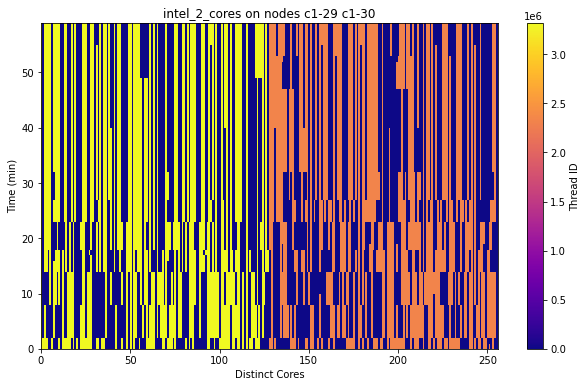

openmpi_2_rank on nodes c1-28 c1-29
Threads running (by Thread ID) on each core:
0 [830022.]
1 [830023.]
2 [830024.]
3 [830025.]
4 [830026.]
5 [830027.]
6 [830028.]
7 [830029.]
8 [830030.]
9 [830031.]
10 [830032.]
11 [830033.]
12 [830034.]
13 [830035.]
14 [830036.]
15 [830037.]
16 [830038.]
17 [830039.]
18 [830040.]
19 [830041.]
20 [830042.]
21 [830043.]
22 [830044.]
23 [830045.]
24 [830046.]
25 [830047.]
26 [830048.]
27 [830049.]
28 [830050.]
29 [830051.]
30 [830052.]
31 [830053.]
32 [830054.]
33 [830055.]
34 [830056.]
35 [830057.]
36 [830058.]
37 [830059.]
38 [830060.]
39 [830061.]
40 [830062.]
41 [830063.]
42 [830064.]
43 [830065.]
44 [830066.]
45 [830067.]
46 [830068.]
47 [830069.]
48 [830070.]
49 [830071.]
50 [830072.]
51 [830073.]
52 [830074.]
53 [830075.]
54 [830076.]
55 [830077.]
56 [830078.]
57 [830079.]
58 [830080.]
59 [830081.]
60 [830082.]
61 [830083.]
62 [830084.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [0.]
73 [0.]
74 [0.]
75 [0.]
76 [0.

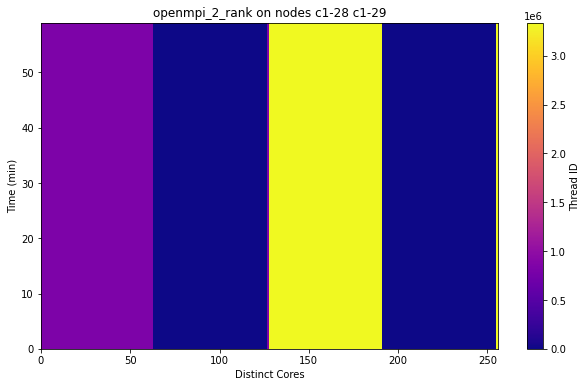

intel_2_none on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [      0. 3325109.]
1 [      0. 3325111.]
2 [      0. 3325113.]
3 [      0. 3325115.]
4 [      0. 3325117.]
5 [      0. 3325119.]
6 [      0. 3325121.]
7 [      0. 3325123.]
8 [      0. 3325125.]
9 [      0. 3325127.]
10 [      0. 3325129.]
11 [0.]
12 [3325133.]
13 [      0. 3325135.]
14 [      0. 3325137.]
15 [      0. 3325139.]
16 [      0. 3325141.]
17 [      0. 3325143.]
18 [0.]
19 [      0. 3325147.]
20 [      0. 3325149.]
21 [      0. 3325151.]
22 [0.]
23 [      0. 3325155.]
24 [      0. 3325157.]
25 [      0. 3325159.]
26 [      0. 3325161.]
27 [0.]
28 [      0. 3325165.]
29 [      0. 3325167.]
30 [0.]
31 [      0. 3325108.]
32 [      0. 3325110.]
33 [      0. 3325112.]
34 [      0. 3325114.]
35 [      0. 3325116.]
36 [      0. 3325118.]
37 [      0. 3325120.]
38 [      0. 3325122.]
39 [      0. 3325124.]
40 [      0. 3325126.]
41 [      0. 3325128.]
42 [3325130.]
43 [      0. 3325132.]
44 [      0.

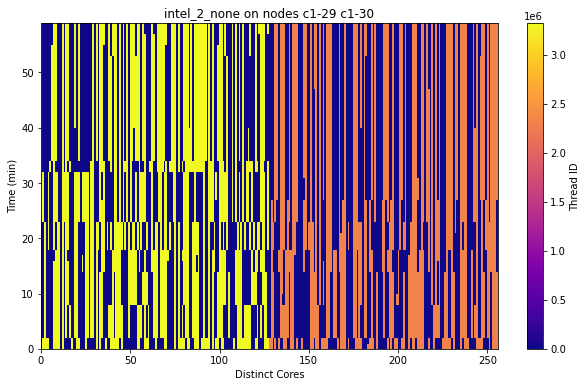

intel_2_rank on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [3328717.]
1 [3328718.]
2 [3328719.]
3 [3328720.]
4 [3328721.]
5 [3328722.]
6 [3328723.]
7 [3328724.]
8 [3328725.]
9 [3328726.]
10 [3328727.]
11 [3328728.]
12 [3328729.]
13 [3328730.]
14 [3328731.]
15 [3328732.]
16 [3328733.]
17 [3328734.]
18 [3328735.]
19 [3328736.]
20 [3328737.]
21 [3328738.]
22 [3328739.]
23 [3328740.]
24 [3328741.]
25 [3328742.]
26 [3328743.]
27 [3328744.]
28 [3328745.]
29 [3328746.]
30 [3328747.]
31 [3328748.]
32 [3328749.]
33 [3328750.]
34 [3328751.]
35 [3328752.]
36 [3328753.]
37 [3328754.]
38 [3328755.]
39 [3328756.]
40 [3328757.]
41 [3328758.]
42 [3328759.]
43 [3328760.]
44 [3328761.]
45 [3328762.]
46 [3328763.]
47 [3328764.]
48 [3328765.]
49 [3328766.]
50 [3328767.]
51 [3328768.]
52 [3328769.]
53 [3328770.]
54 [3328771.]
55 [3328772.]
56 [3328773.]
57 [3328774.]
58 [3328775.]
59 [3328776.]
60 [3328777.]
61 [3328778.]
62 [3328779.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
6

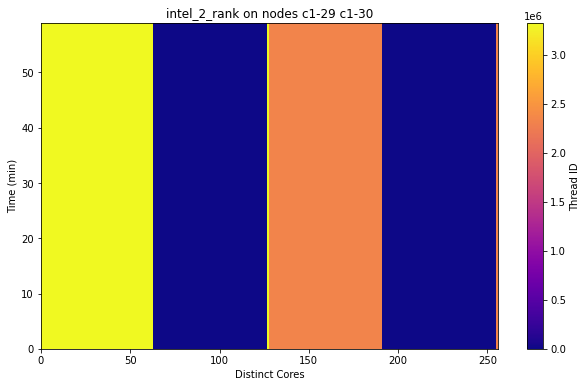

openmpi_1_none on nodes c1-28
Threads running (by Thread ID) on each core:
0 [     0. 846263.]
1 [     0. 846265.]
2 [     0. 846267.]
3 [     0. 846269.]
4 [0.]
5 [     0. 846273.]
6 [     0. 846275.]
7 [     0. 846277.]
8 [     0. 846279.]
9 [     0. 846281.]
10 [     0. 846283.]
11 [     0. 846285.]
12 [     0. 846287.]
13 [     0. 846289.]
14 [     0. 846291.]
15 [     0. 846293.]
16 [     0. 846295.]
17 [     0. 846297.]
18 [     0. 846299.]
19 [     0. 846301.]
20 [     0. 846303.]
21 [     0. 846305.]
22 [     0. 846307.]
23 [     0. 846309.]
24 [     0. 846311.]
25 [0.]
26 [     0. 846315.]
27 [     0. 846317.]
28 [     0. 846319.]
29 [     0. 846321.]
30 [     0. 846323.]
31 [     0. 846262.]
32 [     0. 846264.]
33 [     0. 846266.]
34 [0.]
35 [     0. 846270.]
36 [     0. 846272.]
37 [     0. 846274.]
38 [     0. 846276.]
39 [     0. 846278.]
40 [     0. 846280.]
41 [     0. 846282.]
42 [     0. 846284.]
43 [     0. 846286.]
44 [     0. 846288.]
45 [     0. 846290.]
46 [    

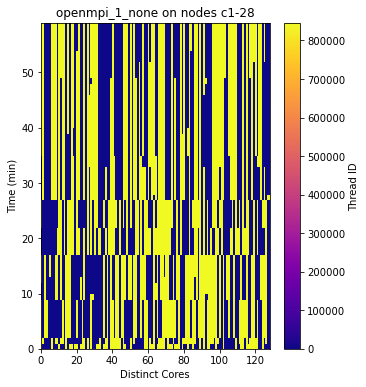

openmpi_1_rank on nodes c1-28
Threads running (by Thread ID) on each core:
0 [851009.]
1 [851010.]
2 [851011.]
3 [851012.]
4 [851013.]
5 [851014.]
6 [851015.]
7 [851016.]
8 [851017.]
9 [851018.]
10 [851019.]
11 [851020.]
12 [851021.]
13 [851022.]
14 [851023.]
15 [851024.]
16 [851025.]
17 [851026.]
18 [851027.]
19 [851028.]
20 [851029.]
21 [851030.]
22 [851031.]
23 [851032.]
24 [851033.]
25 [851034.]
26 [851035.]
27 [851036.]
28 [851037.]
29 [851038.]
30 [851039.]
31 [851040.]
32 [851041.]
33 [851042.]
34 [851043.]
35 [851044.]
36 [851045.]
37 [851046.]
38 [851047.]
39 [851048.]
40 [851049.]
41 [851050.]
42 [851051.]
43 [851052.]
44 [851053.]
45 [851054.]
46 [851055.]
47 [851056.]
48 [851057.]
49 [851058.]
50 [851059.]
51 [851060.]
52 [851061.]
53 [851062.]
54 [851063.]
55 [851064.]
56 [851065.]
57 [851066.]
58 [851067.]
59 [851068.]
60 [851069.]
61 [851070.]
62 [851071.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [0.]
73 [0.]
74 [0.]
75 [0.]
76 [0.]
77 [

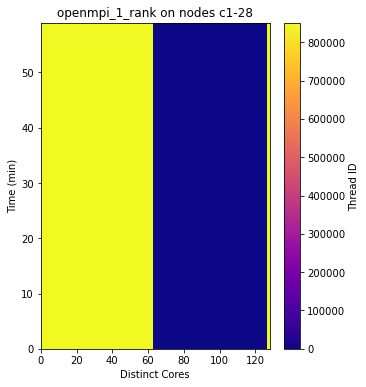

openmpi_2_cores on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [      0. 3332321.]
1 [3332323.]
2 [      0. 3332325.]
3 [      0. 3332327.]
4 [      0. 3332329.]
5 [      0. 3332331.]
6 [0.]
7 [      0. 3332335.]
8 [      0. 3332337.]
9 [      0. 3332339.]
10 [      0. 3332341.]
11 [      0. 3332343.]
12 [0.]
13 [3332347.]
14 [      0. 3332349.]
15 [      0. 3332351.]
16 [      0. 3332353.]
17 [      0. 3332355.]
18 [0.]
19 [      0. 3332359.]
20 [      0. 3332361.]
21 [3332363.]
22 [      0. 3332365.]
23 [      0. 3332367.]
24 [      0. 3332369.]
25 [      0. 3332371.]
26 [      0. 3332373.]
27 [      0. 3332375.]
28 [      0. 3332377.]
29 [      0. 3332379.]
30 [      0. 3332381.]
31 [      0. 3332320.]
32 [3332322.]
33 [      0. 3332324.]
34 [      0. 3332326.]
35 [      0. 3332328.]
36 [      0. 3332330.]
37 [      0. 3332332.]
38 [      0. 3332334.]
39 [      0. 3332336.]
40 [      0. 3332338.]
41 [      0. 3332340.]
42 [      0. 3332342.]
43 [      0. 3332344

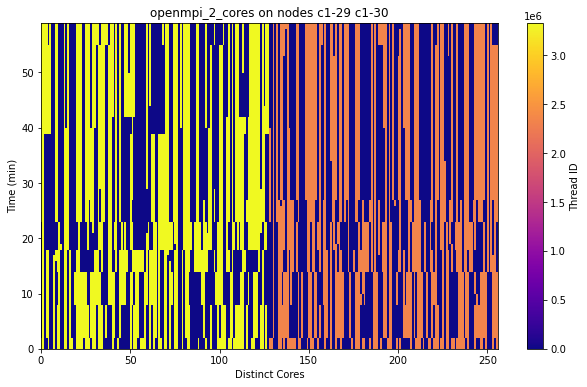

openmpi_4_cores on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [    0. 86957.]
1 [86959.]
2 [0.]
3 [0.]
4 [    0. 86965.]
5 [    0. 86967.]
6 [    0. 86969.]
7 [    0. 86971.]
8 [    0. 86973.]
9 [    0. 86975.]
10 [    0. 86977.]
11 [    0. 86979.]
12 [    0. 86981.]
13 [    0. 86983.]
14 [    0. 86985.]
15 [    0. 86987.]
16 [86989.]
17 [    0. 86991.]
18 [    0. 86993.]
19 [0.]
20 [    0. 86997.]
21 [    0. 86999.]
22 [    0. 87001.]
23 [0.]
24 [    0. 87005.]
25 [    0. 87007.]
26 [    0. 87009.]
27 [    0. 87011.]
28 [    0. 87013.]
29 [    0. 87015.]
30 [    0. 87017.]
31 [    0. 86956.]
32 [    0. 86958.]
33 [    0. 86960.]
34 [86962.]
35 [    0. 86964.]
36 [    0. 86966.]
37 [86968.]
38 [    0. 86970.]
39 [86972.]
40 [    0. 86974.]
41 [    0. 86976.]
42 [    0. 86978.]
43 [    0. 86980.]
44 [    0. 86982.]
45 [    0. 86984.]
46 [    0. 86986.]
47 [    0. 86988.]
48 [    0. 86990.]
49 [    0. 86992.]
50 [0.]
51 [    0. 86996.]
52 [    0. 86998.]

424 [     0. 704880.]
425 [     0. 704882.]
426 [     0. 704884.]
427 [     0. 704886.]
428 [     0. 704888.]
429 [     0. 704890.]
430 [     0. 704892.]
431 [     0. 704894.]
432 [     0. 704896.]
433 [     0. 704898.]
434 [     0. 704900.]
435 [     0. 704902.]
436 [     0. 704904.]
437 [     0. 704906. 705119.]
438 [     0. 704908.]
439 [     0. 704910.]
440 [     0. 704912.]
441 [704914.]
442 [     0. 704916.]
443 [     0. 704918.]
444 [     0. 704920.]
445 [     0. 704922.]
446 [704924.]
447 [     0. 704861.]
448 [0.]
449 [704865.]
450 [     0. 704867. 705279.]
451 [     0. 704869.]
452 [     0. 704871.]
453 [704873.]
454 [704875.]
455 [     0. 704877.]
456 [     0. 704879.]
457 [704881.]
458 [     0. 705260.]
459 [     0. 704885.]
460 [     0. 704887.]
461 [     0. 704889.]
462 [     0. 704891.]
463 [     0. 704893.]
464 [     0. 704895.]
465 [     0. 704897.]
466 [     0. 704899.]
467 [     0. 704901.]
468 [     0. 704903.]
469 [704905.]
470 [     0. 704907.]
471 [     0. 704909

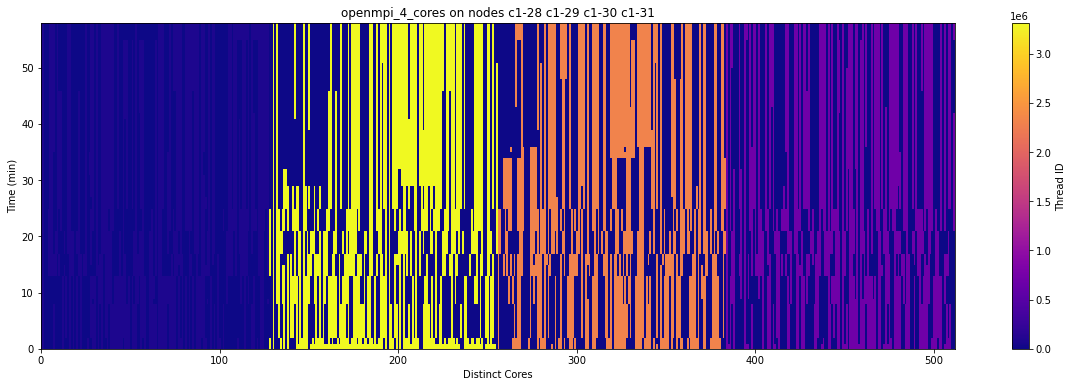

intel_4_none on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [    0. 75690.]
1 [    0. 75692.]
2 [    0. 75694.]
3 [    0. 75696.]
4 [    0. 75698.]
5 [    0. 75700.]
6 [75702.]
7 [    0. 75704.]
8 [    0. 75706.]
9 [    0. 75708.]
10 [    0. 75710.]
11 [    0. 75712.]
12 [    0. 75714.]
13 [0.]
14 [    0. 75718.]
15 [    0. 75720.]
16 [    0. 75722.]
17 [    0. 75724.]
18 [    0. 75726.]
19 [    0. 75728.]
20 [    0. 75730.]
21 [0.]
22 [    0. 75734.]
23 [    0. 75736.]
24 [    0. 75738.]
25 [    0. 75740.]
26 [75742.]
27 [    0. 75744.]
28 [    0. 75746.]
29 [    0. 75748.]
30 [    0. 75750.]
31 [    0. 75689.]
32 [    0. 75691.]
33 [75693.]
34 [    0. 75695.]
35 [    0. 75697.]
36 [0.]
37 [    0. 75701.]
38 [    0. 75703.]
39 [    0. 75705.]
40 [75707.]
41 [    0. 75709.]
42 [    0. 75711.]
43 [    0. 75713.]
44 [    0. 75715.]
45 [    0. 75717.]
46 [    0. 75719.]
47 [    0. 75721.]
48 [    0. 75723.]
49 [    0. 75725.]
50 [    0. 75727.]
51 [75729.]

409 [699720.]
410 [     0. 699722.]
411 [     0. 699724.]
412 [     0. 699726.]
413 [     0. 699728.]
414 [     0. 699730.]
415 [     0. 699669.]
416 [     0. 699671.]
417 [     0. 699673.]
418 [0.]
419 [     0. 699677.]
420 [     0. 699679.]
421 [     0. 699681.]
422 [     0. 699683.]
423 [699685.]
424 [0.]
425 [     0. 699689.]
426 [     0. 699691.]
427 [     0. 699693.]
428 [     0. 699695.]
429 [     0. 699697.]
430 [     0. 699699.]
431 [     0. 699701.]
432 [     0. 699703.]
433 [699705.]
434 [     0. 699707.]
435 [     0. 699709.]
436 [     0. 699711.]
437 [     0. 699713.]
438 [     0. 699715.]
439 [     0. 699717.]
440 [     0. 699719.]
441 [     0. 699721.]
442 [0.]
443 [     0. 699725.]
444 [     0. 699727.]
445 [0.]
446 [     0. 699731.]
447 [     0. 699668.]
448 [0.]
449 [     0. 699672.]
450 [     0. 699674.]
451 [     0. 699676.]
452 [     0. 699678.]
453 [     0. 699680.]
454 [     0. 699682.]
455 [     0. 699684.]
456 [     0. 699686.]
457 [699688.]
458 [     0. 699690

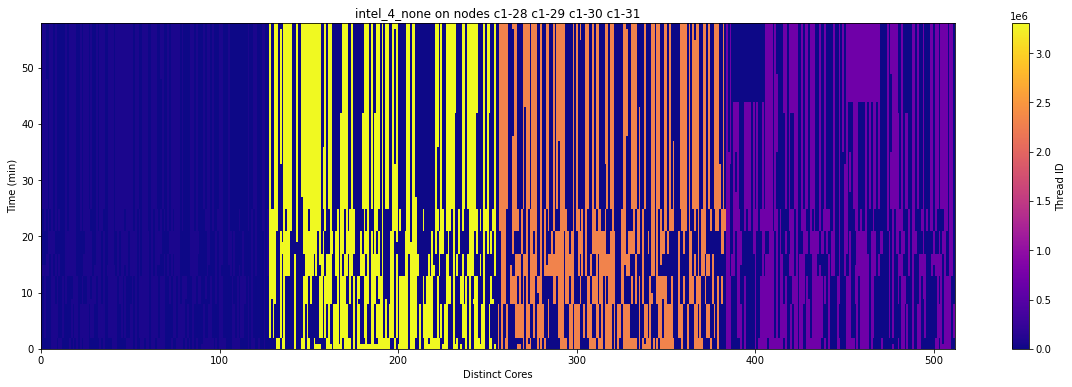

intel_4_rank on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [81403.]
1 [81404.]
2 [81405.]
3 [81406.]
4 [81407.]
5 [81408.]
6 [81409.]
7 [81410.]
8 [81411.]
9 [81412.]
10 [81413.]
11 [81414.]
12 [81415.]
13 [81416.]
14 [81417.]
15 [81418.]
16 [81419.]
17 [81420.]
18 [81421.]
19 [81422.]
20 [81423.]
21 [81424.]
22 [81425.]
23 [81426.]
24 [81427.]
25 [81428.]
26 [81429.]
27 [81430.]
28 [81431.]
29 [81432.]
30 [81433.]
31 [81434.]
32 [81435.]
33 [81436.]
34 [81437.]
35 [81438.]
36 [81439.]
37 [81440.]
38 [81441.]
39 [81442.]
40 [81443.]
41 [81444.]
42 [81445.]
43 [81446.]
44 [81447.]
45 [81448.]
46 [81449.]
47 [81450.]
48 [81451.]
49 [81452.]
50 [81453.]
51 [81454.]
52 [81455.]
53 [81456.]
54 [81457.]
55 [81458.]
56 [81459.]
57 [81460.]
58 [81461.]
59 [81462.]
60 [81463.]
61 [81464.]
62 [81465.]
63 [0.]
64 [0.]
65 [0.]
66 [0.]
67 [0.]
68 [0.]
69 [0.]
70 [0.]
71 [0.]
72 [0.]
73 [0.]
74 [0.]
75 [0.]
76 [0.]
77 [0.]
78 [0.]
79 [0.]
80 [0.]
81 [0.]
82 [0.]
83 

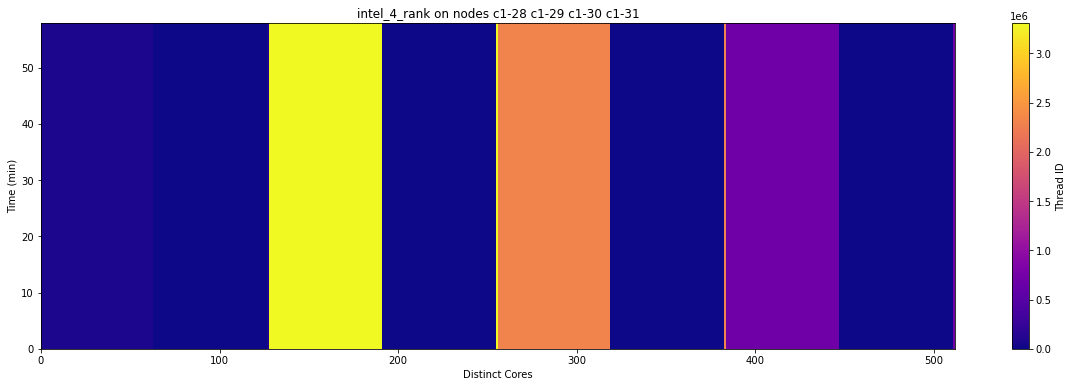

openmpi_1_cores on nodes c1-28
Threads running (by Thread ID) on each core:
0 [     0. 841624.]
1 [     0. 841626.]
2 [     0. 841628.]
3 [     0. 841630.]
4 [     0. 841632.]
5 [     0. 841634.]
6 [     0. 841636.]
7 [     0. 841638.]
8 [     0. 841640.]
9 [     0. 841642.]
10 [     0. 841644.]
11 [     0. 841646.]
12 [     0. 841648.]
13 [     0. 841650.]
14 [     0. 841652.]
15 [     0. 841654.]
16 [     0. 841656.]
17 [     0. 841658.]
18 [0.]
19 [     0. 841662.]
20 [     0. 841664.]
21 [     0. 841666.]
22 [     0. 841668.]
23 [     0. 841670.]
24 [     0. 841672.]
25 [     0. 841674.]
26 [     0. 841676.]
27 [     0. 841678.]
28 [     0. 841680.]
29 [     0. 841682.]
30 [     0. 841684.]
31 [841623.]
32 [     0. 841625.]
33 [     0. 841627.]
34 [     0. 841629.]
35 [     0. 841631.]
36 [     0. 841633.]
37 [     0. 841635.]
38 [     0. 841637.]
39 [     0. 841639.]
40 [     0. 841641.]
41 [     0. 841643.]
42 [     0. 841645.]
43 [     0. 841647.]
44 [     0. 841649.]
45 [     0

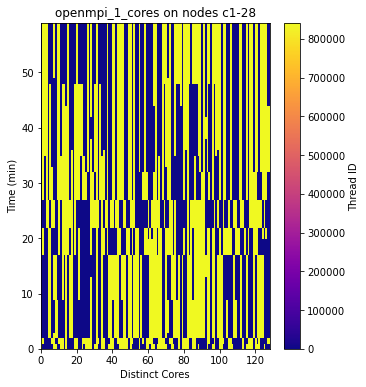

In [21]:
swift_data_for_table = []

for file in swift_onnodes:
    f = open("swift/"+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()[-5:]
    for i in range(1, len(data)):
        if "c1-" in data[i]:
            data_array.append(one_run)
            node = data[i].strip()[-5:]
            one_run = []
        else:   
            array_line = np.array(data[i].split())
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[1]),node]
                        one_run.append(info)
    data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(128)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    title = file + " on nodes"
    nodelist = ""
    for node in nodes:
        nodelist += " "
        nodelist += node
    title += nodelist
    nodelist_arr = nodelist.split()
    print(title)
    threads_used = []
    core_use_count = 0
    cores_w_multiple_threads = 0
    threads_on_multiple_cores = 0
    print("Threads running (by Thread ID) on each core:")
    for i in range(len(all_data[1])):
        print(i, np.unique(np.array(all_data)[:,i]))
        thread_count = 0
        for j in np.unique(np.array(all_data)[:,i]):
            if j > 0:
                threads_used.append(j)
                thread_count += 1
        if len(np.unique(np.array(all_data)[:,i]))>0 and np.unique(np.array(all_data)[:,i])[-1]>0:
            core_use_count += 1
            if thread_count > 1:
                cores_w_multiple_threads += 1
    print("Threads running on multiple cores (Thread ID, number of cores processed on)")
    for i in np.unique(threads_used):
        num_cores_on = threads_used.count(i)
        if num_cores_on > 1:
            print(i, num_cores_on)
            threads_on_multiple_cores += 1
    print("Number of cores in use during the run:", core_use_count)
    print("Number of unique threads used during the run:", len(np.unique(threads_used)))
    print("Number of cores handling multiple threads:", cores_w_multiple_threads)
    print("Number of threads processed on multiple cores:", threads_on_multiple_cores)
    print("Total number of tasks requested:", len(nodelist_arr)*64)
    print("Total number of nodes requested:", len(nodelist_arr))
    swift_data_for_table.append([file, len(nodelist_arr)*64, len(nodelist_arr), core_use_count, len(np.unique(threads_used)), cores_w_multiple_threads, threads_on_multiple_cores])
    locals()["swift_"+file] = all_data
    fig = plt.figure(figsize=(8*(len(all_data[0])/200),6))
    plot = plt.pcolormesh(all_data,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("Thread ID")
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

In [25]:
col_names = ["Calculation Title (MPI, num nodes, cpu-bind)", "Total number of tasks requested", "Total number of nodes requested", "Number of cores in use during the run", "Number of unique threads used during the run", "Number of cores handling multiple threads", "Number of threads processed on multiple cores"]
swift_data_table = pd.DataFrame(swift_data_for_table, columns = col_names)
swift_data_table.sort_values("Calculation Title (MPI, num nodes, cpu-bind)", inplace=True)
print("Thread Assignment to Virtual Cores on Swift")
swift_data_table

Thread Assignment to Virtual Cores on Swift


,"Calculation Title (MPI, num nodes, cpu-bind)",Total number of tasks requested,Total number of nodes requested,Number of cores in use during the run,Number of unique threads used during the run,Number of cores handling multiple threads,Number of threads processed on multiple cores
2,intel_1_cores,64,1,67,64,0,3
4,intel_1_none,64,1,127,64,0,63
5,intel_1_rank,64,1,64,64,0,0
7,intel_2_cores,128,2,239,129,1,111
9,intel_2_none,128,2,233,129,0,104
10,intel_2_rank,128,2,128,128,0,0
3,intel_4_cores,256,4,477,306,46,217
15,intel_4_none,256,4,477,282,22,217
16,intel_4_rank,256,4,256,260,4,0
17,openmpi_1_cores,64,1,126,64,0,62


### Analyze Thread Assignment to Physical Cores

openmpi_4_none on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [92791.]
1 [92793.]
2 [92795.]
3 [92797.]
4 [92799.]
5 [92801.]
6 [92803.]
7 [92805.]
8 [92807.]
9 [92809.]
10 [92811.]
11 [92813.]
12 [92815.]
13 [92817.]
14 [92819.]
15 [92821.]
16 [92823.]
17 [92825.]
18 [92827.]
19 [92829.]
20 [92831.]
21 [92833.]
22 [92835.]
23 [92837.]
24 [92839.]
25 [92841.]
26 [92843.]
27 [92845.]
28 [92847.]
29 [92849.]
30 [92851.]
31 [92790.]
32 [92792.]
33 [92794.]
34 [92796.]
35 [92798.]
36 [92800.]
37 [92802.]
38 [92804.]
39 [92806.]
40 [92808.]
41 [92810.]
42 [92812.]
43 [92814.]
44 [92816.]
45 [92818.]
46 [92820.]
47 [92822.]
48 [92824.]
49 [92826.]
50 [92828.]
51 [92830.]
52 [92832.]
53 [92834.]
54 [92836.]
55 [92838.]
56 [92840.]
57 [92842.]
58 [92844.]
59 [92846.]
60 [92848.]
61 [92850.]
62 [92852.]
63 [      0.   92789. 3408888.]
64 [3316101.]
65 [3316103. 6632378.]
66 [3316105.]
67 [3316107.]
68 [3316109.]
69 [3316111.]
70 [3316113. 6632387.]
71 [3316115. 

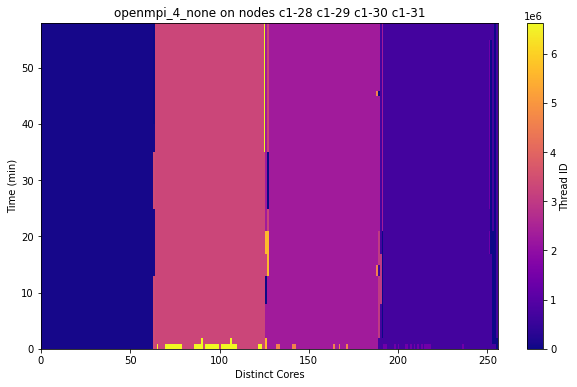

openmpi_4_rank on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [3417288.]
1 [3417290.]
2 [3417292.]
3 [3417294.]
4 [3417296.]
5 [3417298.]
6 [3417300.]
7 [3417302.]
8 [3417304.]
9 [3417306.]
10 [3417308.]
11 [3417310.]
12 [3417312.]
13 [3417314.]
14 [3417316.]
15 [3417318.]
16 [3417320.]
17 [3417322.]
18 [3417324.]
19 [3417326.]
20 [3417328.]
21 [3417330.]
22 [3417332.]
23 [3417334.]
24 [3417336.]
25 [3417338.]
26 [3417340.]
27 [3417342.]
28 [3417344.]
29 [3417346.]
30 [3417348.]
31 [3417350.]
32 [3417352.]
33 [3417354.]
34 [3417356.]
35 [3417358.]
36 [3417360.]
37 [3417362.]
38 [3417364.]
39 [3417366.]
40 [3417368.]
41 [3417370.]
42 [3417372.]
43 [3417374.]
44 [3417376.]
45 [3417378.]
46 [3417380.]
47 [3417382.]
48 [3417384.]
49 [3417386.]
50 [3417388.]
51 [3417390.]
52 [3417392.]
53 [3417394.]
54 [3417396.]
55 [3417398.]
56 [3417400.]
57 [3417402.]
58 [3417404.]
59 [3417406.]
60 [3417408.]
61 [3417410.]
62 [2419104.]
63 [5639428.]
64 [3030985.]
65 [303

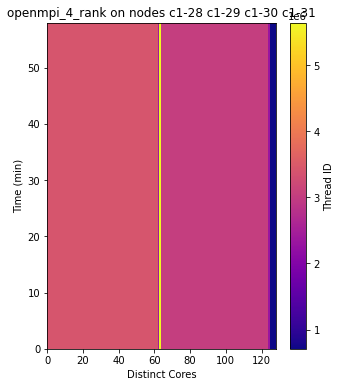

intel_1_cores on nodes c1-28
Threads running (by Thread ID) on each core:
0 [65752.]
1 [65754.]
2 [65756.]
3 [65758.]
4 [65760.]
5 [65762.]
6 [65764.]
7 [65766.]
8 [65768.]
9 [65770.]
10 [65772.]
11 [65774.]
12 [65776.]
13 [65778.]
14 [65780.]
15 [65782.]
16 [65784.]
17 [65786.]
18 [65788.]
19 [65790.]
20 [65792.]
21 [65794.]
22 [65796.]
23 [65798.]
24 [65800.]
25 [65802.]
26 [65804.]
27 [65806.]
28 [65808.]
29 [65810.]
30 [65812.]
31 [65751.]
32 [65753.]
33 [65755.]
34 [65757.]
35 [65759.]
36 [65761.]
37 [65763.]
38 [65765.]
39 [65767.]
40 [65769.]
41 [65771.]
42 [65773.]
43 [65775.]
44 [65777.]
45 [65779.]
46 [65781.]
47 [65783.]
48 [65785.]
49 [65787.]
50 [65789.]
51 [65791.]
52 [65793.]
53 [65795.]
54 [65797.]
55 [65799.]
56 [65801.]
57 [65803.]
58 [65805.]
59 [65807.]
60 [65809.]
61 [65811.]
62 [65813.]
63 [65750.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 37
Number of unique threads used during the run: 64
N

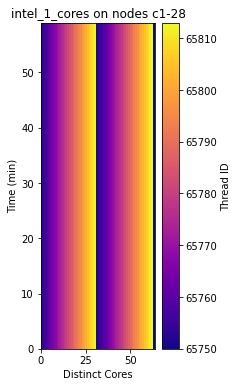

intel_4_cores on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [70090.]
1 [70092.]
2 [70094.]
3 [70096.]
4 [70098.]
5 [70100.]
6 [70102.]
7 [70104.]
8 [70106.]
9 [70108.]
10 [70110.]
11 [70112.]
12 [70114.]
13 [70116.]
14 [70118.]
15 [70120.]
16 [70122.]
17 [70124.]
18 [70126.]
19 [70128.]
20 [70130.]
21 [70132.]
22 [70134.]
23 [70136.]
24 [70138.]
25 [70140.]
26 [70142.]
27 [70144.]
28 [70146.]
29 [70148.]
30 [70150.]
31 [70089.]
32 [70091.]
33 [70093.]
34 [70095.]
35 [70097.]
36 [70099.]
37 [70101.]
38 [70103.]
39 [70105.]
40 [70107.]
41 [70109.]
42 [70111.]
43 [70113.]
44 [70115.]
45 [70117.]
46 [70119.]
47 [70121.]
48 [70123.]
49 [70125.]
50 [70127.]
51 [70129.]
52 [70131.]
53 [70133.]
54 [70135.]
55 [70137.]
56 [70139.]
57 [70141.]
58 [70143.]
59 [70145.]
60 [70147.]
61 [70149.]
62 [70151.]
63 [  70088. 3375408.]
64 [3305322.]
65 [3305324.]
66 [3305326.]
67 [3305328.]
68 [3305330.]
69 [3305332.]
70 [3305334.]
71 [3305336.]
72 [3305338.]
73 [3305340. 

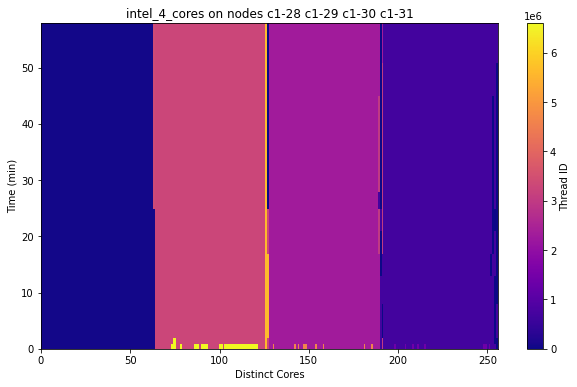

intel_1_none on nodes c1-30
Threads running (by Thread ID) on each core:
0 [2334957.]
1 [2334959.]
2 [2334961.]
3 [2334963.]
4 [2334965.]
5 [2334967.]
6 [2334969.]
7 [2334971.]
8 [2334973.]
9 [2334975.]
10 [2334977.]
11 [2334979.]
12 [2334981.]
13 [2334983.]
14 [2334985.]
15 [2334987.]
16 [2334989.]
17 [2334991.]
18 [2334993.]
19 [2334995.]
20 [2334997.]
21 [2334999.]
22 [2335001.]
23 [2335003.]
24 [2335005.]
25 [2335007.]
26 [2335009.]
27 [2335011.]
28 [2335013.]
29 [2335015.]
30 [2335017.]
31 [2334956.]
32 [2334958.]
33 [2334960.]
34 [2334962.]
35 [2334964.]
36 [2334966.]
37 [2334968.]
38 [2334970.]
39 [2334972.]
40 [2334974.]
41 [2334976.]
42 [2334978.]
43 [2334980.]
44 [2334982.]
45 [2334984.]
46 [2334986.]
47 [2334988.]
48 [2334990.]
49 [2334992.]
50 [2334994.]
51 [2334996.]
52 [2334998.]
53 [2335000.]
54 [2335002.]
55 [2335004.]
56 [2335006.]
57 [2335008.]
58 [2335010.]
59 [2335012.]
60 [2335014.]
61 [2335016.]
62 [2335018. 4669973.]
63 [      0. 2334955.]
Threads running on mult

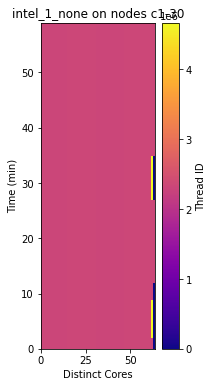

intel_1_rank on nodes c1-28
Threads running (by Thread ID) on each core:
0 [836920.]
1 [836921.]
2 [836922.]
3 [836923.]
4 [836924.]
5 [836925.]
6 [836926.]
7 [836927.]
8 [836928.]
9 [836929.]
10 [836930.]
11 [836931.]
12 [836932.]
13 [836933.]
14 [836934.]
15 [836935.]
16 [836936.]
17 [836937.]
18 [836938.]
19 [836939.]
20 [836940.]
21 [836941.]
22 [836942.]
23 [836943.]
24 [836944.]
25 [836945.]
26 [836946.]
27 [836947.]
28 [836948.]
29 [836949.]
30 [836950.]
31 [836951.]
32 [836952.]
33 [836953.]
34 [836954.]
35 [836955.]
36 [836956.]
37 [836957.]
38 [836958.]
39 [836959.]
40 [836960.]
41 [836961.]
42 [836962.]
43 [836963.]
44 [836964.]
45 [836965.]
46 [836966.]
47 [836967.]
48 [836968.]
49 [836969.]
50 [836970.]
51 [836971.]
52 [836972.]
53 [836973.]
54 [836974.]
55 [836975.]
56 [836976.]
57 [836977.]
58 [836978.]
59 [836979.]
60 [836980.]
61 [836981.]
62 [836982.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 63


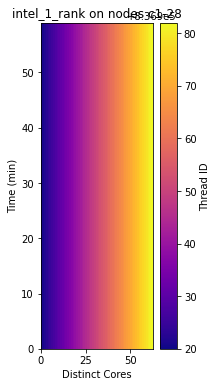

openmpi_2_none on nodes c1-28 c1-29
Threads running (by Thread ID) on each core:
0 [824906.]
1 [824908.]
2 [824910.]
3 [824912.]
4 [824914.]
5 [824916.]
6 [824918.]
7 [824920.]
8 [824922.]
9 [824924.]
10 [824926.]
11 [824928.]
12 [824930.]
13 [824932.]
14 [824934.]
15 [824936.]
16 [824938.]
17 [824940.]
18 [824942.]
19 [824944.]
20 [824946.]
21 [824948.]
22 [824950.]
23 [824952.]
24 [824954.]
25 [824956.]
26 [824958.]
27 [824960.]
28 [824962.]
29 [824964.]
30 [824966.]
31 [824905.]
32 [824907.]
33 [824909.]
34 [824911.]
35 [824913.]
36 [824915.]
37 [824917.]
38 [824919.]
39 [824921.]
40 [824923.]
41 [824925.]
42 [824927.]
43 [824929.]
44 [824931.]
45 [824933.]
46 [824935.]
47 [824937.]
48 [824939.]
49 [824941.]
50 [824943.]
51 [824945.]
52 [824947.]
53 [824949.]
54 [824951.]
55 [824953.]
56 [824955.]
57 [824957.]
58 [824959.]
59 [824961.]
60 [824963.]
61 [824965.]
62 [824967.]
63 [      0.  824904. 3335943. 4160847.]
64 [3335945.]
65 [3335947.]
66 [3335949.]
67 [3335951.]
68 [3335953.]

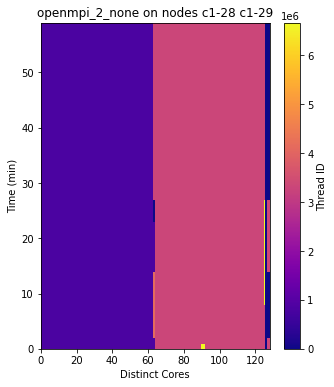

intel_2_cores on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [3321538.]
1 [3321540.]
2 [3321542.]
3 [3321544.]
4 [3321546.]
5 [3321548.]
6 [3321550.]
7 [3321552.]
8 [3321554.]
9 [3321556.]
10 [3321558.]
11 [3321560.]
12 [3321562.]
13 [3321564.]
14 [3321566.]
15 [3321568.]
16 [3321570.]
17 [3321572.]
18 [3321574.]
19 [3321576.]
20 [3321578.]
21 [3321580.]
22 [3321582.]
23 [3321584.]
24 [3321586.]
25 [3321588.]
26 [3321590.]
27 [3321592.]
28 [3321594.]
29 [3321596.]
30 [3321598.]
31 [3321537.]
32 [3321539.]
33 [3321541.]
34 [3321543.]
35 [3321545.]
36 [3321547.]
37 [3321549.]
38 [3321551.]
39 [3321553.]
40 [3321555.]
41 [3321557.]
42 [3321559.]
43 [3321561.]
44 [3321563.]
45 [3321565.]
46 [3321567.]
47 [3321569.]
48 [3321571.]
49 [3321573.]
50 [3321575.]
51 [3321577.]
52 [3321579.]
53 [3321581.]
54 [3321583.]
55 [3321585.]
56 [3321587.]
57 [3321589.]
58 [3321591.]
59 [3321593.]
60 [3321595.]
61 [3321597.]
62 [3321599.]
63 [      0. 3321536. 5644773.]
64 [2323239.]
65

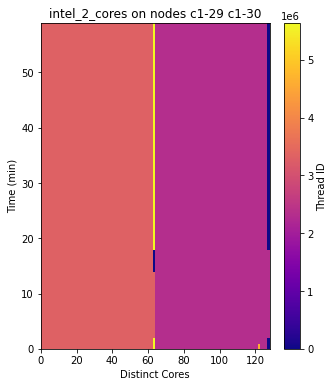

openmpi_2_rank on nodes c1-28 c1-29
Threads running (by Thread ID) on each core:
0 [4168818.]
1 [4168820.]
2 [4168822.]
3 [4168824.]
4 [4168826.]
5 [4168828.]
6 [4168830.]
7 [4168832.]
8 [4168834.]
9 [4168836.]
10 [4168838.]
11 [4168840.]
12 [4168842.]
13 [4168844.]
14 [4168846.]
15 [4168848.]
16 [4168850.]
17 [4168852.]
18 [4168854.]
19 [4168856.]
20 [4168858.]
21 [4168860.]
22 [4168862.]
23 [4168864.]
24 [4168866.]
25 [4168868.]
26 [4168870.]
27 [4168872.]
28 [4168874.]
29 [4168876.]
30 [4168878.]
31 [4168880.]
32 [4168882.]
33 [4168884.]
34 [4168886.]
35 [4168888.]
36 [4168890.]
37 [4168892.]
38 [4168894.]
39 [4168896.]
40 [4168898.]
41 [4168900.]
42 [4168902.]
43 [4168904.]
44 [4168906.]
45 [4168908.]
46 [4168910.]
47 [4168912.]
48 [4168914.]
49 [4168916.]
50 [4168918.]
51 [4168920.]
52 [4168922.]
53 [4168924.]
54 [4168926.]
55 [4168928.]
56 [4168930.]
57 [4168932.]
58 [4168934.]
59 [4168936.]
60 [4168938.]
61 [4168940.]
62 [830084.]
63 [3338795.]
Threads running on multiple cores 

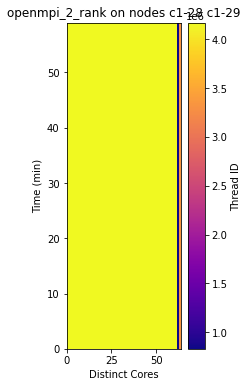

intel_2_none on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [3325109.]
1 [3325111.]
2 [3325113.]
3 [3325115.]
4 [3325117.]
5 [3325119.]
6 [3325121.]
7 [3325123.]
8 [3325125.]
9 [3325127.]
10 [3325129.]
11 [3325131.]
12 [3325133.]
13 [3325135.]
14 [3325137.]
15 [3325139.]
16 [3325141.]
17 [3325143.]
18 [3325145.]
19 [3325147.]
20 [3325149.]
21 [3325151.]
22 [3325153.]
23 [3325155.]
24 [3325157.]
25 [3325159.]
26 [3325161.]
27 [3325163.]
28 [3325165.]
29 [3325167.]
30 [3325169.]
31 [3325108.]
32 [3325110.]
33 [3325112.]
34 [3325114.]
35 [3325116.]
36 [3325118.]
37 [3325120.]
38 [3325122.]
39 [3325124.]
40 [3325126.]
41 [3325128.]
42 [3325130.]
43 [3325132.]
44 [3325134.]
45 [3325136.]
46 [3325138.]
47 [3325140.]
48 [3325142.]
49 [3325144.]
50 [3325146.]
51 [3325148.]
52 [3325150.]
53 [3325152.]
54 [3325154.]
55 [3325156.]
56 [3325158.]
57 [3325160.]
58 [3325162.]
59 [3325164.]
60 [3325166.]
61 [3325168.]
62 [3325170. 6650277.]
63 [      0. 2326040. 3325107.]
64 [2326

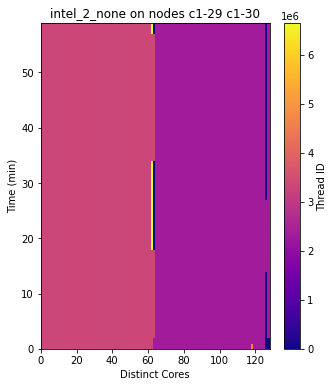

intel_2_rank on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [5657429.]
1 [5657431.]
2 [5657433.]
3 [5657435.]
4 [5657437.]
5 [5657439.]
6 [5657441.]
7 [5657443.]
8 [5657445.]
9 [5657447.]
10 [5657449.]
11 [5657451.]
12 [5657453.]
13 [5657455.]
14 [5657457.]
15 [5657459.]
16 [5657461.]
17 [5657463.]
18 [5657465.]
19 [5657467.]
20 [5657469.]
21 [5657471.]
22 [5657473.]
23 [5657475.]
24 [5657477.]
25 [5657479.]
26 [5657481.]
27 [5657483.]
28 [5657485.]
29 [5657487.]
30 [5657489.]
31 [5657491.]
32 [5657493.]
33 [5657495.]
34 [5657497.]
35 [5657499.]
36 [5657501.]
37 [5657503.]
38 [5657505.]
39 [5657507.]
40 [5657509.]
41 [5657511.]
42 [5657513.]
43 [5657515.]
44 [5657517.]
45 [5657519.]
46 [5657521.]
47 [5657523.]
48 [5657525.]
49 [5657527.]
50 [5657529.]
51 [5657531.]
52 [5657533.]
53 [5657535.]
54 [5657537.]
55 [5657539.]
56 [5657541.]
57 [5657543.]
58 [5657545.]
59 [5657547.]
60 [5657549.]
61 [5657551.]
62 [3328779.]
63 [2328711.]
Threads running on multiple cores (

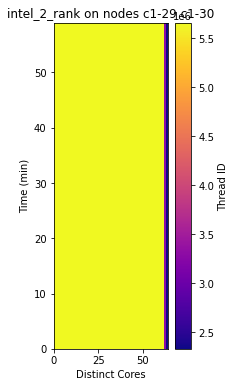

openmpi_1_none on nodes c1-28
Threads running (by Thread ID) on each core:
0 [846263.]
1 [846265.]
2 [846267.]
3 [846269.]
4 [846271.]
5 [846273.]
6 [846275.]
7 [846277.]
8 [846279.]
9 [846281.]
10 [846283.]
11 [846285.]
12 [846287.]
13 [846289.]
14 [846291.]
15 [846293.]
16 [846295.]
17 [846297.]
18 [846299.]
19 [846301.]
20 [846303.]
21 [846305.]
22 [846307.]
23 [846309.]
24 [846311.]
25 [846313.]
26 [846315.]
27 [846317.]
28 [846319.]
29 [846321.]
30 [846323.]
31 [846262.]
32 [846264.]
33 [846266.]
34 [846268.]
35 [846270.]
36 [846272.]
37 [846274.]
38 [846276.]
39 [846278.]
40 [846280.]
41 [846282.]
42 [846284.]
43 [846286.]
44 [846288.]
45 [846290.]
46 [846292.]
47 [846294.]
48 [846296.]
49 [846298.]
50 [846300.]
51 [846302.]
52 [846304.]
53 [846306.]
54 [846308.]
55 [846310.]
56 [846312.]
57 [846314.]
58 [846316.]
59 [846318.]
60 [846320.]
61 [846322.]
62 [ 846324. 1692585.]
63 [     0. 846261.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of

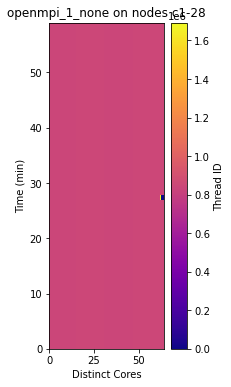

openmpi_1_rank on nodes c1-28
Threads running (by Thread ID) on each core:
0 [851009.]
1 [851010.]
2 [851011.]
3 [851012.]
4 [851013.]
5 [851014.]
6 [851015.]
7 [851016.]
8 [851017.]
9 [851018.]
10 [851019.]
11 [851020.]
12 [851021.]
13 [851022.]
14 [851023.]
15 [851024.]
16 [851025.]
17 [851026.]
18 [851027.]
19 [851028.]
20 [851029.]
21 [851030.]
22 [851031.]
23 [851032.]
24 [851033.]
25 [851034.]
26 [851035.]
27 [851036.]
28 [851037.]
29 [851038.]
30 [851039.]
31 [851040.]
32 [851041.]
33 [851042.]
34 [851043.]
35 [851044.]
36 [851045.]
37 [851046.]
38 [851047.]
39 [851048.]
40 [851049.]
41 [851050.]
42 [851051.]
43 [851052.]
44 [851053.]
45 [851054.]
46 [851055.]
47 [851056.]
48 [851057.]
49 [851058.]
50 [851059.]
51 [851060.]
52 [851061.]
53 [851062.]
54 [851063.]
55 [851064.]
56 [851065.]
57 [851066.]
58 [851067.]
59 [851068.]
60 [851069.]
61 [851070.]
62 [851071.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 6

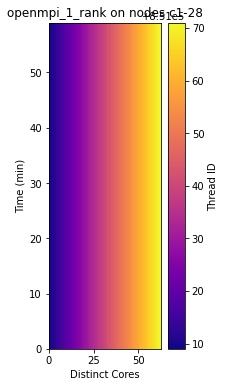

openmpi_2_cores on nodes c1-29 c1-30
Threads running (by Thread ID) on each core:
0 [3332321.]
1 [3332323.]
2 [3332325.]
3 [3332327.]
4 [3332329.]
5 [3332331.]
6 [3332333.]
7 [3332335.]
8 [3332337.]
9 [3332339.]
10 [3332341.]
11 [3332343.]
12 [3332345.]
13 [3332347.]
14 [3332349.]
15 [3332351.]
16 [3332353.]
17 [3332355.]
18 [3332357.]
19 [3332359.]
20 [3332361.]
21 [3332363.]
22 [3332365.]
23 [3332367.]
24 [3332369.]
25 [3332371.]
26 [3332373.]
27 [3332375.]
28 [3332377.]
29 [3332379.]
30 [3332381.]
31 [3332320.]
32 [3332322.]
33 [3332324.]
34 [3332326.]
35 [3332328.]
36 [3332330.]
37 [3332332.]
38 [3332334.]
39 [3332336.]
40 [3332338.]
41 [3332340.]
42 [3332342.]
43 [3332344.]
44 [3332346.]
45 [3332348.]
46 [3332350.]
47 [3332352.]
48 [3332354.]
49 [3332356.]
50 [3332358.]
51 [3332360.]
52 [3332362.]
53 [3332364.]
54 [3332366.]
55 [3332368.]
56 [3332370.]
57 [3332372.]
58 [3332374.]
59 [3332376.]
60 [3332378.]
61 [3332380.]
62 [3332382.]
63 [      0. 2331503. 3332319. 5663822.]
64 [2

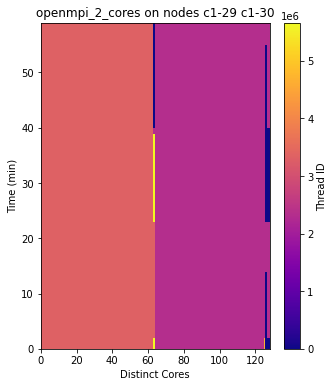

openmpi_4_cores on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [86957.]
1 [86959.]
2 [86961.]
3 [86963.]
4 [86965.]
5 [86967.]
6 [86969.]
7 [86971.]
8 [86973.]
9 [86975.]
10 [86977.]
11 [86979.]
12 [86981.]
13 [86983.]
14 [86985.]
15 [86987.]
16 [86989.]
17 [86991.]
18 [86993.]
19 [86995.]
20 [86997.]
21 [86999.]
22 [87001.]
23 [87003.]
24 [87005.]
25 [87007.]
26 [87009.]
27 [87011.]
28 [87013.]
29 [87015.]
30 [87017.]
31 [86956.]
32 [86958.]
33 [86960.]
34 [86962.]
35 [86964.]
36 [86966.]
37 [86968.]
38 [86970.]
39 [86972.]
40 [86974.]
41 [86976.]
42 [86978.]
43 [86980.]
44 [86982.]
45 [86984.]
46 [86986.]
47 [86988.]
48 [86990.]
49 [86992.]
50 [86994.]
51 [86996.]
52 [86998.]
53 [87000.]
54 [87002.]
55 [87004.]
56 [87006.]
57 [87008.]
58 [87010.]
59 [87012.]
60 [87014.]
61 [87016.]
62 [ 87018. 173973.]
63 [      0.   86955. 3313442. 3400397.]
64 [3313444.]
65 [3313446.]
66 [3313448.]
67 [3313450.]
68 [3313452.]
69 [3313454.]
70 [3313456.]
71 [3313458.

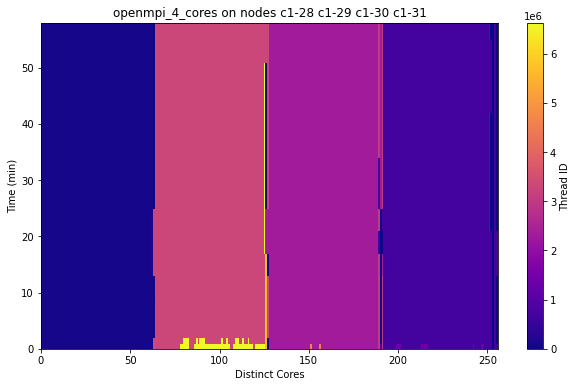

intel_4_none on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [75690.]
1 [75692.]
2 [75694.]
3 [75696.]
4 [75698.]
5 [75700.]
6 [75702.]
7 [75704.]
8 [75706.]
9 [75708.]
10 [75710.]
11 [75712.]
12 [75714.]
13 [75716.]
14 [75718.]
15 [75720.]
16 [75722.]
17 [75724.]
18 [75726.]
19 [75728.]
20 [75730.]
21 [75732.]
22 [75734.]
23 [75736.]
24 [75738.]
25 [75740.]
26 [ 75742. 151815.]
27 [75744.]
28 [75746.]
29 [75748.]
30 [75750.]
31 [75689.]
32 [75691.]
33 [75693.]
34 [75695.]
35 [75697.]
36 [75699.]
37 [75701.]
38 [75703.]
39 [75705.]
40 [75707.]
41 [75709.]
42 [75711.]
43 [75713.]
44 [75715.]
45 [75717.]
46 [75719.]
47 [75721.]
48 [75723.]
49 [75725.]
50 [75727.]
51 [75729.]
52 [75731.]
53 [75733.]
54 [75735.]
55 [75737.]
56 [75739.]
57 [75741.]
58 [75743.]
59 [75745.]
60 [75747.]
61 [75749.]
62 [ 75751. 151439.]
63 [  75688. 3308115. 3383803.]
64 [3308117.]
65 [3308119.]
66 [3308121.]
67 [3308123.]
68 [3308125.]
69 [3308127.]
70 [3308129.]
71 [3308131. 66

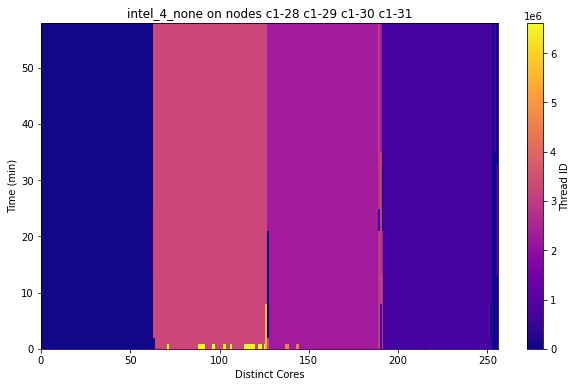

intel_4_rank on nodes c1-28 c1-29 c1-30 c1-31
Threads running (by Thread ID) on each core:
0 [3392199.]
1 [3392201.]
2 [3392203.]
3 [3392205.]
4 [3392207.]
5 [3392209.]
6 [3392211.]
7 [3392213. 3392471.]
8 [3392215.]
9 [3392217.]
10 [3392219.]
11 [3392221.]
12 [3392223.]
13 [3392225.]
14 [3392227. 3392477.]
15 [3392229. 3392477.]
16 [3392231.]
17 [3392233.]
18 [3392235.]
19 [3392237.]
20 [3392239.]
21 [3392241.]
22 [3392243.]
23 [3392245.]
24 [3392247.]
25 [3392249.]
26 [3392251.]
27 [3392253.]
28 [3392255.]
29 [3392257.]
30 [3392259.]
31 [3392261.]
32 [3392263.]
33 [3392265.]
34 [3392267.]
35 [3392269.]
36 [3392271.]
37 [3392273.]
38 [3392275.]
39 [3392277.]
40 [3392279.]
41 [3392281.]
42 [3392283.]
43 [3392285.]
44 [3392287.]
45 [3392289.]
46 [3392291.]
47 [3392293.]
48 [3392295.]
49 [3392297.]
50 [3392299.]
51 [3392301.]
52 [3392303.]
53 [3392305.]
54 [3392307.]
55 [3392309.]
56 [3392311.]
57 [3392313.]
58 [3392315.]
59 [3392317.]
60 [3392319.]
61 [3392321.]
62 [2394011.]
63 [562334

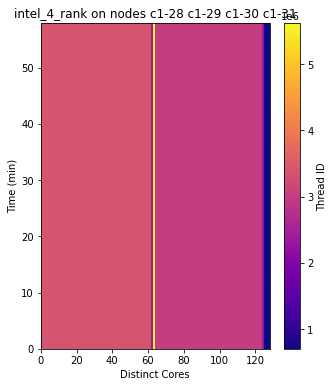

openmpi_1_cores on nodes c1-28
Threads running (by Thread ID) on each core:
0 [841624.]
1 [841626.]
2 [841628.]
3 [841630.]
4 [841632.]
5 [841634.]
6 [841636.]
7 [841638.]
8 [841640.]
9 [841642.]
10 [841644.]
11 [841646.]
12 [841648.]
13 [841650.]
14 [841652.]
15 [841654.]
16 [841656.]
17 [841658.]
18 [841660.]
19 [841662.]
20 [841664.]
21 [841666.]
22 [841668.]
23 [841670.]
24 [841672.]
25 [841674.]
26 [841676.]
27 [841678.]
28 [841680.]
29 [841682.]
30 [841684.]
31 [841623.]
32 [841625.]
33 [841627.]
34 [841629.]
35 [841631.]
36 [841633.]
37 [841635.]
38 [841637.]
39 [841639.]
40 [841641.]
41 [841643.]
42 [841645.]
43 [841647.]
44 [841649.]
45 [841651.]
46 [841653.]
47 [841655.]
48 [841657.]
49 [841659.]
50 [841661.]
51 [841663.]
52 [841665.]
53 [841667.]
54 [841669.]
55 [841671.]
56 [841673.]
57 [841675.]
58 [841677.]
59 [841679.]
60 [841681.]
61 [841683.]
62 [ 841685. 1683307.]
63 [     0. 841622.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number o

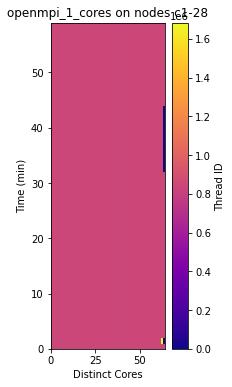

In [23]:
swift_data_for_table_phys = []

for file in swift_onnodes:
    f = open("swift/"+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()[-5:]
    for i in range(1, len(data)):
        if "c1-" in data[i]:
            data_array.append(one_run)
            node = data[i].strip()[-5:]
            one_run = []
        else:   
            array_line = np.array(data[i].split())
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[1]),node]
                        one_run.append(info)
    data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(max_core)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    all_data_phys_cores = []
    for row in all_data:
        new_row = []
        for index, i in enumerate(row):
            divisor = int(index)//64
            if divisor%2==0:
                new_row.append(i)
            else:
                new_row[int(index-64*(divisor+1)/2)]+=i
        all_data_phys_cores.append(new_row)
    title = file + " on nodes"
    nodelist = ""
    for node in nodes:
        nodelist += " "
        nodelist += node
    title += nodelist
    nodelist_arr = nodelist.split()
    print(title)
    threads_used = []
    core_use_count = 0
    cores_w_multiple_threads = 0
    threads_on_multiple_cores = 0
    print("Threads running (by Thread ID) on each core:")
    for i in range(len(all_data_phys_cores[1])):
        print(i, np.unique(np.array(all_data_phys_cores)[:,i]))
        thread_count = 0
        for j in np.unique(np.array(all_data_phys_cores)[:,i]):
            if j > 0:
                threads_used.append(j)
                thread_count += 1
        if len(np.unique(np.array(all_data_phys_cores)[:,i]))>0 and np.unique(np.array(all_data)[:,i])[-1]>0:
            core_use_count += 1
            if thread_count > 1:
                cores_w_multiple_threads += 1
    print("Threads running on multiple cores (Thread ID, number of cores processed on)")
    for i in np.unique(threads_used):
        num_cores_on = threads_used.count(i)
        if num_cores_on > 1:
            print(i, num_cores_on)
            threads_on_multiple_cores += 1
    print("Number of cores in use during the run:", core_use_count)
    print("Number of unique threads used during the run:", len(np.unique(threads_used)))
    print("Number of cores handling multiple threads:", cores_w_multiple_threads)
    print("Number of threads processed on multiple cores:", threads_on_multiple_cores)
    print("Total number of tasks requested:", len(nodelist_arr)*64)
    print("Total number of nodes requested:", len(nodelist_arr))
    swift_data_for_table_phys.append([file, len(nodelist_arr)*64, len(nodelist_arr), core_use_count, len(np.unique(threads_used)), cores_w_multiple_threads, threads_on_multiple_cores])
    fig = plt.figure(figsize=(8*(len(all_data_phys_cores[0])/200),6))
    plot = plt.pcolormesh(all_data_phys_cores,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("Thread ID")
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

In [26]:
col_names = ["Calculation Title (MPI, num nodes, cpu-bind)", "Total number of tasks requested", "Total number of nodes requested", "Number of cores in use during the run", "Number of unique threads used during the run", "Number of cores handling multiple threads", "Number of threads processed on multiple cores"]
swift_data_table = pd.DataFrame(swift_data_for_table_phys, columns = col_names)
swift_data_table.sort_values("Calculation Title (MPI, num nodes, cpu-bind)", inplace=True)
print("Thread Assignment to Physical Cores on Swift")
swift_data_table

Thread Assignment to Physical Cores on Swift


,"Calculation Title (MPI, num nodes, cpu-bind)",Total number of tasks requested,Total number of nodes requested,Number of cores in use during the run,Number of unique threads used during the run,Number of cores handling multiple threads,Number of threads processed on multiple cores
2,intel_1_cores,64,1,37,64,0,0
4,intel_1_none,64,1,63,65,1,0
5,intel_1_rank,64,1,63,63,0,0
7,intel_2_cores,128,2,115,130,2,0
9,intel_2_none,128,2,121,130,3,1
10,intel_2_rank,128,2,64,64,0,0
3,intel_4_cores,256,4,234,304,47,7
15,intel_4_none,256,4,240,287,28,5
16,intel_4_rank,256,4,128,131,4,1
17,openmpi_1_cores,64,1,63,65,1,0


# Eagle

On Eagle, calculations requested full nodes (36 cores/node). This was set using "--tasks-per-node=36 -n 36*[num nodes]".

### Summary of Eagle cpu-bind Results¶

The graphs in the [Plot CPU Usage Over Time for Each Core](#Plot-CPU-Usage-Over-Time-for-Each-Core) section show us that setting cpu-bind=cores and setting cpu-bind=rank have a similar effect on Eagle using intelmpi and openmpi for all node counts, and CPU usage seems to be evenly distributed over the same number of cores throughout the run. Without setting cpu-bind, CPUs have small gaps of time in which they aren't used. 

The table in the [Analyze Thread Assignment to Cores](#Analyze-Thread-Assignment-to-Cores) section show us that all calculations with cpu-bind = cores or cpu-bind = rank have a core count and a thread count that is approximately equal to the number of tasks requested, and each core is assigned a single unique thread to process throughout the runtime. However, for calculations without a cpu-bind setting, all threads are processed over multiple cores, and we can see up to 25 distinct threads processed on the same core throughout the runtime.

In [29]:
#eagle onnodes data
eagle_dir = "eagle_onnodes_data"

eagle_onnodes = [f for f in listdir(eagle_dir) if (".ipynb" not in f)]

In [30]:
eagle_onnodes

['openmpi_4_none',
 'openmpi_4_rank',
 'intel_1_cores',
 'intel_4_cores',
 'intel_1_none',
 'intel_1_rank',
 'openmpi_2_none',
 'intel_2_cores',
 'openmpi_2_rank',
 'intel_2_none',
 'intel_2_rank',
 'openmpi_1_none',
 'openmpi_1_rank',
 'openmpi_2_cores',
 'openmpi_4_cores',
 'intel_4_none',
 'intel_4_rank',
 'openmpi_1_cores']

### Plot CPU Usage Over Time for Each Core

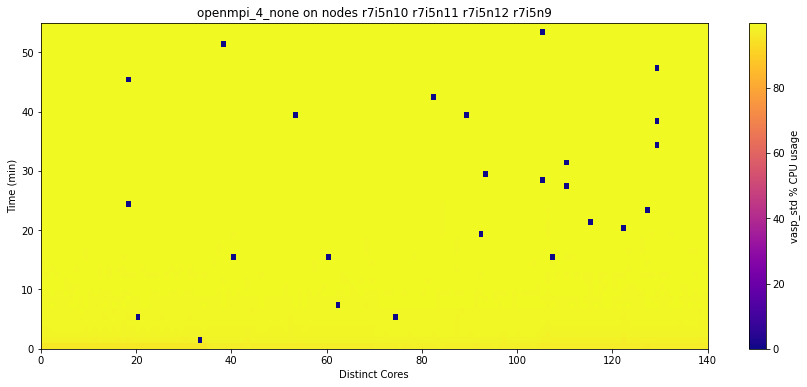

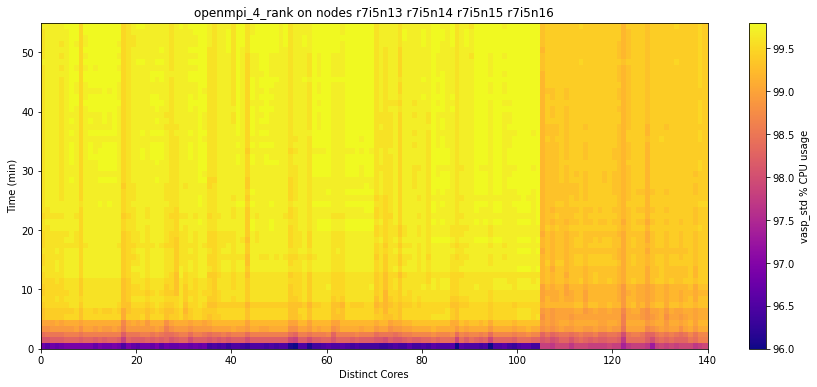

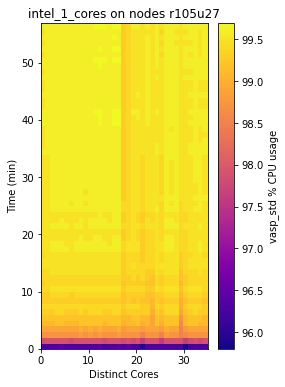

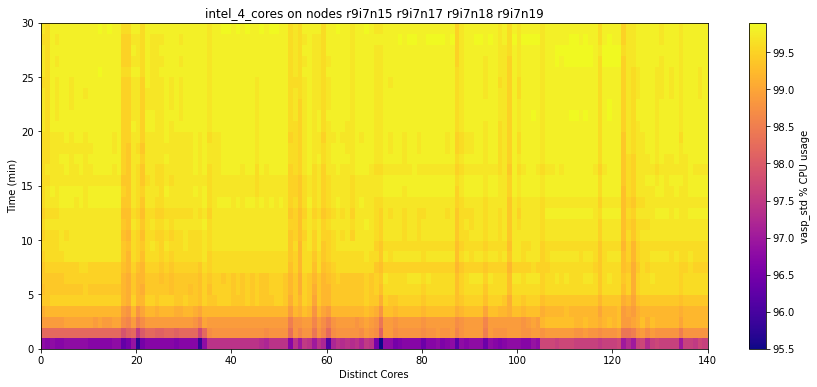

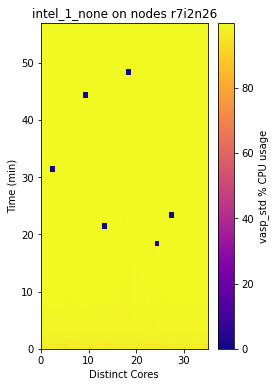

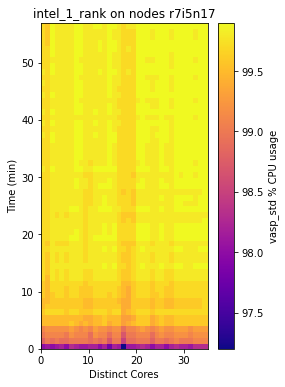

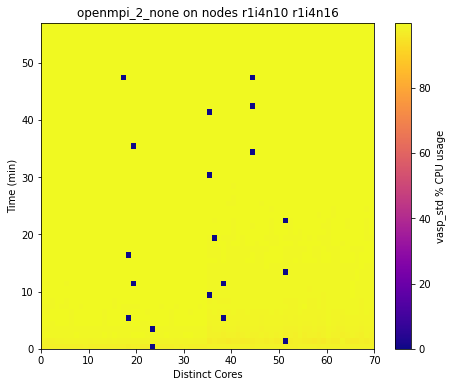

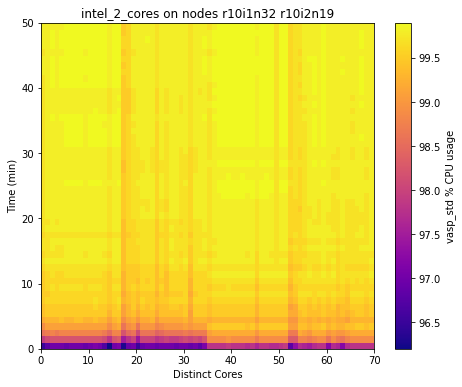

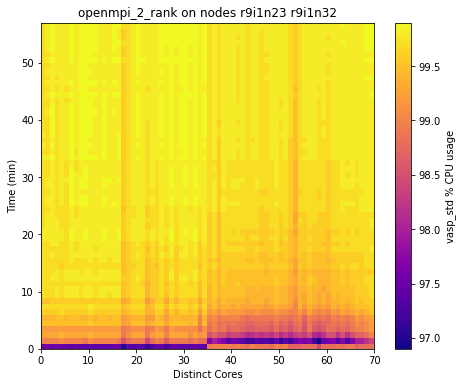

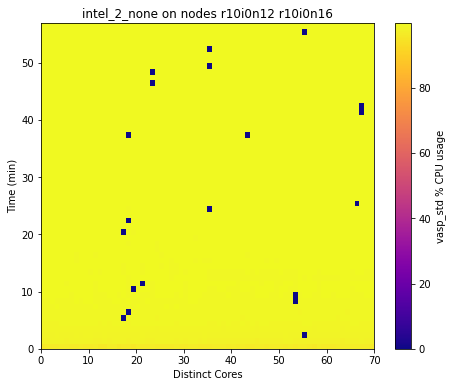

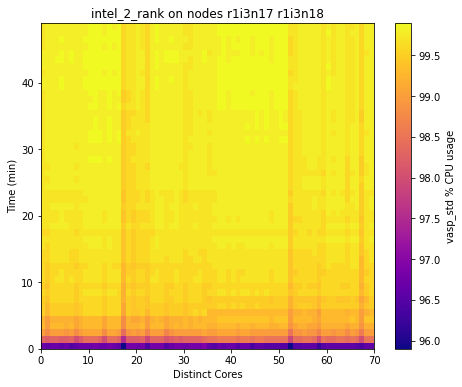

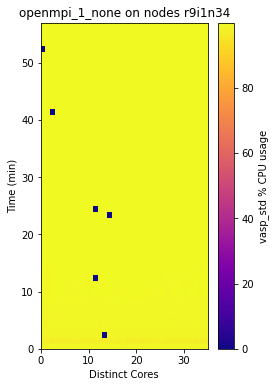

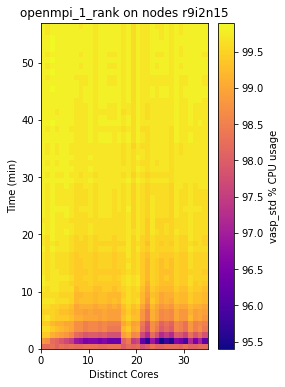

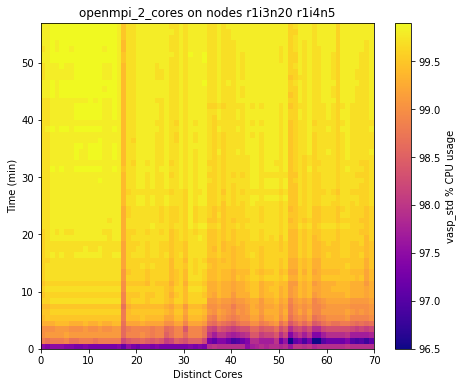

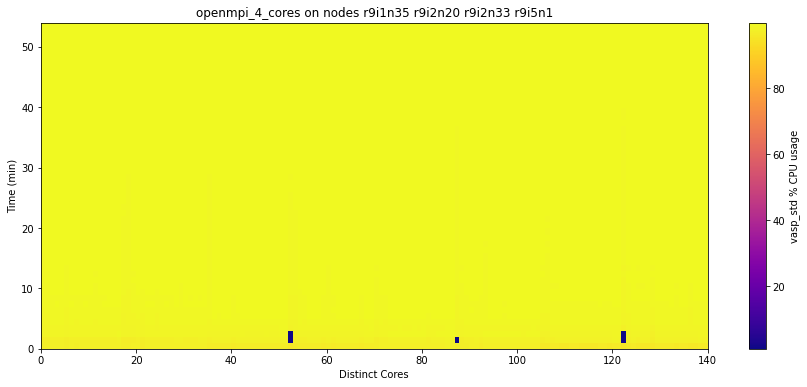

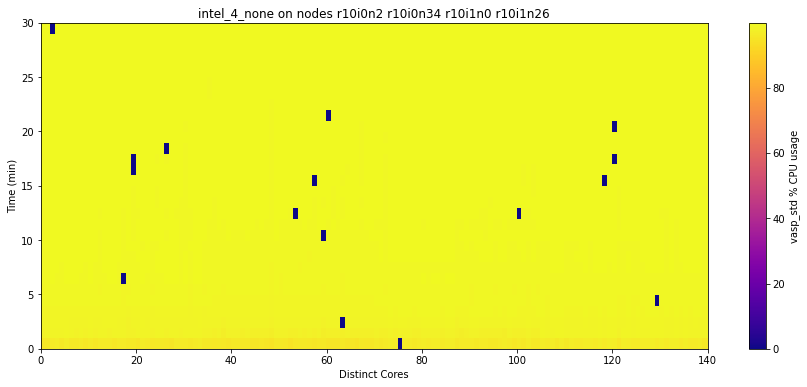

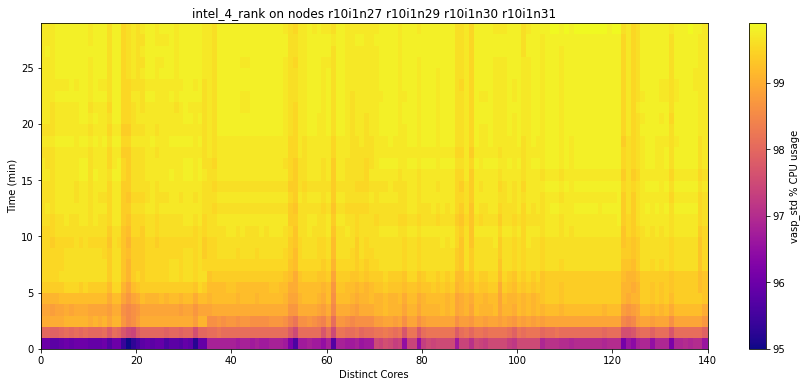

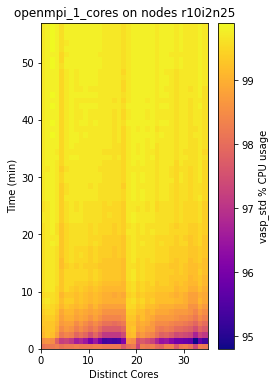

In [18]:
for file in eagle_onnodes:
    f = open('eagle/'+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()
    for i in range(1, len(data)):
        array_line = np.array(data[i].split())
        if "r" in array_line[0]:
            if len(one_run)>1:
                data_array.append(one_run)
            node = array_line[0]
            one_run = []
        else:   
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[4]),node]
                        one_run.append(info)
    if len(one_run)>1:
        data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(max_core)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    locals()["eagle_"+file] = plot_data
    fig = plt.figure(figsize=(8*(len(all_data[0])/75),6))
    plot = plt.pcolormesh(all_data,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("vasp_std % CPU usage")
    title = file + " on nodes"
    for node in nodes:
        title += " "
        title += node
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

### Analyze Thread Assignment to Cores

openmpi_4_none on nodes r7i5n10 r7i5n11 r7i5n12 r7i5n9
Threads running (by Thread ID) on each core:
0 [47448. 47449. 47452. 47453. 47456. 47457. 47458. 47460. 47464. 47466.
 47467. 47478. 47479. 47482. 47483.]
1 [47454. 47455. 47456. 47457. 47460. 47464. 47468. 47469. 47470. 47471.
 47472. 47473. 47482.]
2 [47451. 47455. 47461. 47462. 47464. 47466. 47468. 47470. 47473. 47474.
 47475. 47478. 47482. 47483.]
3 [47448. 47449. 47451. 47453. 47454. 47458. 47464. 47465. 47471. 47482.]
4 [47450. 47451. 47453. 47456. 47457. 47460. 47462. 47463. 47464. 47465.
 47472. 47474. 47476.]
5 [47448. 47457. 47458. 47462. 47464. 47465. 47466. 47470. 47474. 47480.]
6 [47452. 47454. 47457. 47459. 47460. 47466. 47467. 47473. 47475. 47479.
 47483.]
7 [47450. 47453. 47454. 47457. 47459. 47461. 47462. 47465. 47469. 47471.
 47472. 47479. 47480.]
8 [47453. 47455. 47457. 47460. 47462. 47463. 47465. 47472. 47473. 47474.
 47480. 47482.]
9 [47450. 47455. 47459. 47463. 47464. 47466. 47467. 47468. 47474. 47477.
 47480.

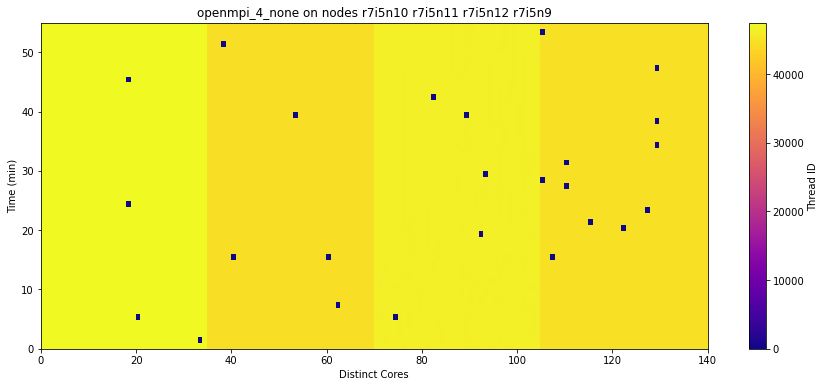

openmpi_4_rank on nodes r7i5n13 r7i5n14 r7i5n15 r7i5n16
Threads running (by Thread ID) on each core:
0 [44647.]
1 [44648.]
2 [44649.]
3 [44650.]
4 [44651.]
5 [44652.]
6 [44653.]
7 [44654.]
8 [44655.]
9 [44656.]
10 [44657.]
11 [44658.]
12 [44659.]
13 [44660.]
14 [44661.]
15 [44662.]
16 [44663.]
17 [44664.]
18 [44665.]
19 [44666.]
20 [44667.]
21 [44668.]
22 [44669.]
23 [44670.]
24 [44671.]
25 [44672.]
26 [44673.]
27 [44674.]
28 [44675.]
29 [44676.]
30 [44677.]
31 [44678.]
32 [44679.]
33 [44680.]
34 [44681.]
35 [46663.]
36 [46664.]
37 [46665.]
38 [46666.]
39 [46667.]
40 [46668.]
41 [46669.]
42 [46670.]
43 [46671.]
44 [46672.]
45 [46673.]
46 [46674.]
47 [46675.]
48 [46676.]
49 [46677.]
50 [46678.]
51 [46679.]
52 [46680.]
53 [46681.]
54 [46682.]
55 [46683.]
56 [46684.]
57 [46685.]
58 [46686.]
59 [46687.]
60 [46688.]
61 [46689.]
62 [46690.]
63 [46691.]
64 [46692.]
65 [46693.]
66 [46694.]
67 [46695.]
68 [46696.]
69 [46697.]
70 [44679.]
71 [44680.]
72 [44681.]
73 [44682.]
74 [44683.]
75 [44684

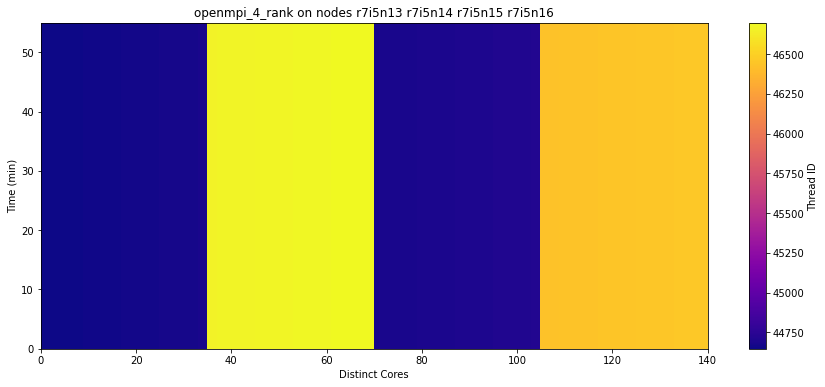

intel_1_cores on nodes r105u27
Threads running (by Thread ID) on each core:
0 [33336.]
1 [33338.]
2 [33340.]
3 [33342.]
4 [33344.]
5 [33346.]
6 [33348.]
7 [33350.]
8 [33352.]
9 [33354.]
10 [33356.]
11 [33358.]
12 [33360.]
13 [33362.]
14 [33364.]
15 [33366.]
16 [33368.]
17 [33335.]
18 [33337.]
19 [33339.]
20 [33341.]
21 [33343.]
22 [33345.]
23 [33347.]
24 [33349.]
25 [33351.]
26 [33353.]
27 [33355.]
28 [33357.]
29 [33359.]
30 [33361.]
31 [33363.]
32 [33365.]
33 [33367.]
34 [33369.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 35
Number of unique threads used during the run: 35
Number of cores handling multiple threads: 0
Number of threads processed on multiple cores: 0
Total number of tasks requested: 36
Total number of nodes requested: 1
Max number of threads processed by a single core: 1


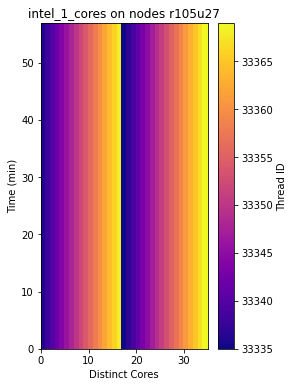

intel_4_cores on nodes r9i7n15 r9i7n17 r9i7n18 r9i7n19
Threads running (by Thread ID) on each core:
0 [52248.]
1 [52250.]
2 [52252.]
3 [52254.]
4 [52256.]
5 [52258.]
6 [52260.]
7 [52262.]
8 [52264.]
9 [52266.]
10 [52268.]
11 [52270.]
12 [52272.]
13 [52274.]
14 [52276.]
15 [52278.]
16 [52280.]
17 [52247.]
18 [52249.]
19 [52251.]
20 [52253.]
21 [52255.]
22 [52257.]
23 [52259.]
24 [52261.]
25 [52263.]
26 [52265.]
27 [52267.]
28 [52269.]
29 [52271.]
30 [52273.]
31 [52275.]
32 [52277.]
33 [52279.]
34 [52281.]
35 [50328.]
36 [50330.]
37 [50332.]
38 [50334.]
39 [50336.]
40 [50338.]
41 [50340.]
42 [50342.]
43 [50344.]
44 [50346.]
45 [50348.]
46 [50350.]
47 [50352.]
48 [50354.]
49 [50356.]
50 [50358.]
51 [50360.]
52 [50327.]
53 [50329.]
54 [50331.]
55 [50333.]
56 [50335.]
57 [50337.]
58 [50339.]
59 [50341.]
60 [50343.]
61 [50345.]
62 [50347.]
63 [50349.]
64 [50351.]
65 [50353.]
66 [50355.]
67 [50357.]
68 [50359.]
69 [50361.]
70 [40590.]
71 [40592.]
72 [40594.]
73 [40596.]
74 [40598.]
75 [40600.

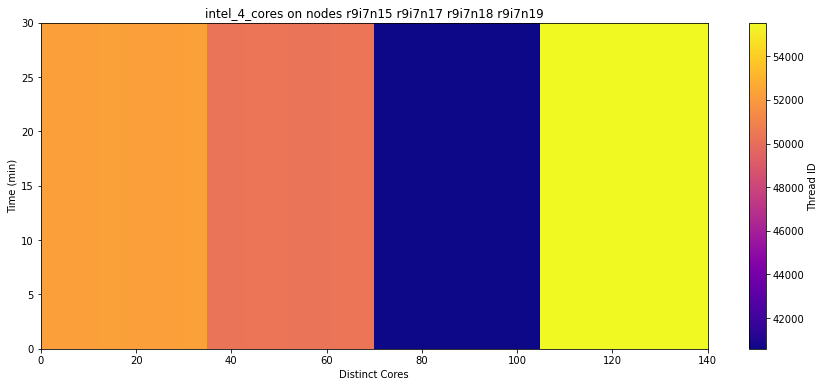

intel_1_none on nodes r7i2n26
Threads running (by Thread ID) on each core:
0 [46108. 46111. 46116. 46119. 46120. 46122. 46131. 46133. 46138. 46139.]
1 [46106. 46108. 46119. 46121. 46127. 46128. 46141.]
2 [    0. 46109. 46116. 46119. 46127.]
3 [46121. 46122. 46126. 46128. 46134.]
4 [46110. 46116. 46126. 46127. 46128. 46133. 46137. 46139.]
5 [46108. 46116. 46127. 46133. 46134. 46137.]
6 [46108. 46128. 46134.]
7 [46108. 46110. 46139. 46140.]
8 [46116. 46119. 46128. 46140. 46141.]
9 [    0. 46109. 46116.]
10 [46137. 46138.]
11 [46110. 46119. 46120.]
12 [46111. 46121. 46122.]
13 [    0. 46106. 46118. 46126. 46127. 46128. 46140.]
14 [46106. 46110. 46120. 46133. 46141.]
15 [46106. 46126. 46128. 46133. 46139.]
16 [46106. 46108. 46110. 46118.]
17 [46107. 46112. 46113. 46114. 46115. 46117. 46122. 46123. 46124. 46125.
 46131. 46132. 46138. 46139. 46140. 46141.]
18 [    0. 46107. 46111. 46113. 46115. 46117. 46118. 46119. 46123. 46129.
 46131. 46132. 46136. 46140.]
19 [46107. 46111. 46122. 46123. 4

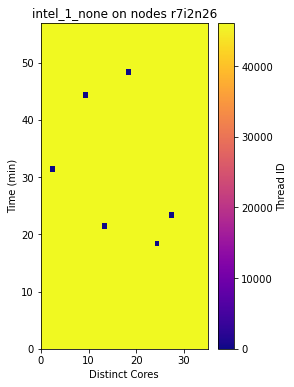

intel_1_rank on nodes r7i5n17
Threads running (by Thread ID) on each core:
0 [44909.]
1 [44910.]
2 [44911.]
3 [44912.]
4 [44913.]
5 [44914.]
6 [44915.]
7 [44916.]
8 [44917.]
9 [44918.]
10 [44919.]
11 [44920.]
12 [44921.]
13 [44922.]
14 [44923.]
15 [44924.]
16 [44925.]
17 [44926.]
18 [44927.]
19 [44928.]
20 [44929.]
21 [44930.]
22 [44931.]
23 [44932.]
24 [44933.]
25 [44934.]
26 [44935.]
27 [44936.]
28 [44937.]
29 [44938.]
30 [44939.]
31 [44940.]
32 [44941.]
33 [44942.]
34 [44943.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 35
Number of unique threads used during the run: 35
Number of cores handling multiple threads: 0
Number of threads processed on multiple cores: 0
Total number of tasks requested: 36
Total number of nodes requested: 1
Max number of threads processed by a single core: 1


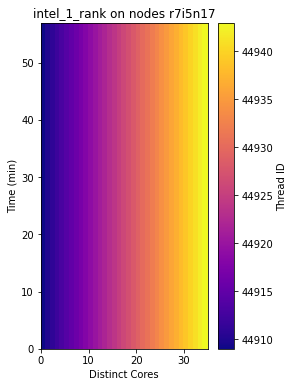

openmpi_2_none on nodes r1i4n10 r1i4n16
Threads running (by Thread ID) on each core:
0 [248416. 248421. 248425. 248428. 248429. 248430. 248431. 248433. 248434.
 248435. 248436. 248437. 248438. 248439. 248446. 248447. 248448. 248449.
 248451.]
1 [248420. 248425. 248426. 248427. 248429. 248430. 248433. 248436. 248437.
 248440. 248448. 248449. 248450.]
2 [248419. 248420. 248422. 248423. 248425. 248428. 248431. 248432. 248433.
 248435. 248436. 248437. 248438. 248442. 248446. 248448. 248449. 248450.
 248451.]
3 [248418. 248422. 248423. 248425. 248426. 248428. 248429. 248430. 248436.
 248437. 248438. 248439. 248443. 248444. 248445. 248446. 248447.]
4 [248416. 248417. 248419. 248423. 248425. 248426. 248427. 248430. 248432.
 248440. 248441. 248447. 248448. 248449.]
5 [248416. 248418. 248419. 248420. 248422. 248424. 248426. 248427. 248429.
 248430. 248432. 248435. 248439. 248440. 248441. 248448. 248449. 248451.]
6 [248418. 248419. 248421. 248422. 248423. 248424. 248425. 248432. 248434.
 248438.

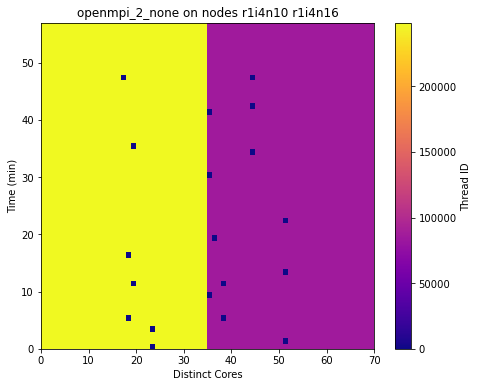

intel_2_cores on nodes r10i1n32 r10i2n19
Threads running (by Thread ID) on each core:
0 [48269.]
1 [48271.]
2 [48273.]
3 [48275.]
4 [48277.]
5 [48279.]
6 [48281.]
7 [48283.]
8 [48285.]
9 [48287.]
10 [48289.]
11 [48291.]
12 [48293.]
13 [48295.]
14 [48297.]
15 [48299.]
16 [48301.]
17 [48268.]
18 [48270.]
19 [48272.]
20 [48274.]
21 [48276.]
22 [48278.]
23 [48280.]
24 [48282.]
25 [48284.]
26 [48286.]
27 [48288.]
28 [48290.]
29 [48292.]
30 [48294.]
31 [48296.]
32 [48298.]
33 [48300.]
34 [48302.]
35 [58190.]
36 [58192.]
37 [58194.]
38 [58196.]
39 [58198.]
40 [58200.]
41 [58202.]
42 [58204.]
43 [58206.]
44 [58208.]
45 [58210.]
46 [58212.]
47 [58214.]
48 [58216.]
49 [58218.]
50 [58220.]
51 [58222.]
52 [58189.]
53 [58191.]
54 [58193.]
55 [58195.]
56 [58197.]
57 [58199.]
58 [58201.]
59 [58203.]
60 [58205.]
61 [58207.]
62 [58209.]
63 [58211.]
64 [58213.]
65 [58215.]
66 [58217.]
67 [58219.]
68 [58221.]
69 [58223.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number o

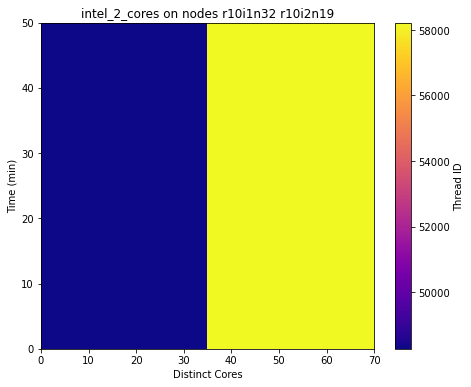

openmpi_2_rank on nodes r9i1n23 r9i1n32
Threads running (by Thread ID) on each core:
0 [161487.]
1 [161488.]
2 [161489.]
3 [161490.]
4 [161491.]
5 [161492.]
6 [161493.]
7 [161494.]
8 [161495.]
9 [161496.]
10 [161497.]
11 [161498.]
12 [161499.]
13 [161500.]
14 [161501.]
15 [161502.]
16 [161503.]
17 [161504.]
18 [161505.]
19 [161506.]
20 [161507.]
21 [161508.]
22 [161509.]
23 [161510.]
24 [161511.]
25 [161512.]
26 [161513.]
27 [161514.]
28 [161515.]
29 [161516.]
30 [161517.]
31 [161518.]
32 [161519.]
33 [161520.]
34 [161521.]
35 [249439.]
36 [249440.]
37 [249441.]
38 [249442.]
39 [249443.]
40 [249444.]
41 [249445.]
42 [249446.]
43 [249447.]
44 [249448.]
45 [249449.]
46 [249450.]
47 [249451.]
48 [249452.]
49 [249453.]
50 [249454.]
51 [249455.]
52 [249456.]
53 [249457.]
54 [249458.]
55 [249459.]
56 [249460.]
57 [249461.]
58 [249462.]
59 [249463.]
60 [249464.]
61 [249465.]
62 [249466.]
63 [249467.]
64 [249468.]
65 [249469.]
66 [249470.]
67 [249471.]
68 [249472.]
69 [249473.]
Threads running

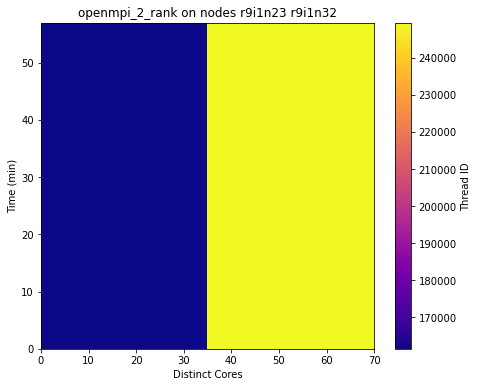

intel_2_none on nodes r10i0n12 r10i0n16
Threads running (by Thread ID) on each core:
0 [46920. 46923. 46926. 46929. 46931. 46933. 46937. 46938. 46943. 46944.
 46945. 46946. 46947. 46949. 46953. 46954.]
1 [46920. 46923. 46927. 46932. 46934. 46936. 46937. 46943. 46949. 46950.
 46951. 46954.]
2 [46921. 46923. 46924. 46927. 46931. 46932. 46933. 46934. 46935. 46938.
 46944. 46950. 46951. 46954.]
3 [46923. 46924. 46925. 46926. 46927. 46928. 46933. 46934. 46940. 46943.
 46945. 46949.]
4 [46921. 46923. 46924. 46928. 46933. 46938. 46940. 46941. 46953. 46954.]
5 [46922. 46923. 46924. 46931. 46933. 46937. 46939. 46955.]
6 [46923. 46928. 46929. 46932. 46933. 46943. 46944. 46945. 46948. 46950.
 46952. 46954.]
7 [46923. 46929. 46932. 46934. 46936. 46943. 46947. 46952. 46954.]
8 [46920. 46925. 46926. 46929. 46931. 46933. 46938. 46948. 46949.]
9 [46925. 46929. 46930. 46931. 46932. 46939. 46947. 46950. 46953. 46955.]
10 [46921. 46925. 46928. 46930. 46935. 46942. 46945. 46947. 46948. 46953.]
11 [46923. 

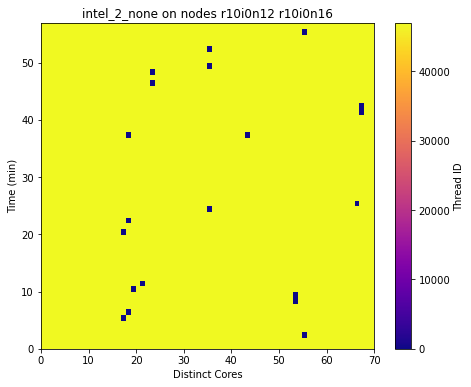

intel_2_rank on nodes r1i3n17 r1i3n18
Threads running (by Thread ID) on each core:
0 [247986.]
1 [247987.]
2 [247988.]
3 [247989.]
4 [247990.]
5 [247991.]
6 [247992.]
7 [247993.]
8 [247994.]
9 [247995.]
10 [247996.]
11 [247997.]
12 [247998.]
13 [247999.]
14 [248000.]
15 [248001.]
16 [248002.]
17 [248003.]
18 [248004.]
19 [248005.]
20 [248006.]
21 [248007.]
22 [248008.]
23 [248009.]
24 [248010.]
25 [248011.]
26 [248012.]
27 [248013.]
28 [248014.]
29 [248015.]
30 [248016.]
31 [248017.]
32 [248018.]
33 [248019.]
34 [248020.]
35 [68912.]
36 [68913.]
37 [68914.]
38 [68915.]
39 [68916.]
40 [68917.]
41 [68918.]
42 [68919.]
43 [68920.]
44 [68921.]
45 [68922.]
46 [68923.]
47 [68924.]
48 [68925.]
49 [68926.]
50 [68927.]
51 [68928.]
52 [68929.]
53 [68930.]
54 [68931.]
55 [68932.]
56 [68933.]
57 [68934.]
58 [68935.]
59 [68936.]
60 [68937.]
61 [68938.]
62 [68939.]
63 [68940.]
64 [68941.]
65 [68942.]
66 [68943.]
67 [68944.]
68 [68945.]
69 [68946.]
Threads running on multiple cores (Thread ID, number

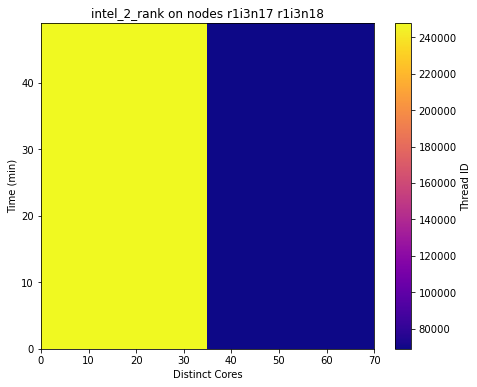

openmpi_1_none on nodes r9i1n34
Threads running (by Thread ID) on each core:
0 [    0. 35209. 35211. 35212. 35213. 35214. 35215. 35216. 35218. 35220.
 35222. 35223. 35225. 35226. 35228. 35229. 35232. 35237. 35239. 35240.]
1 [35209. 35210. 35218. 35219. 35222. 35223. 35224. 35227. 35228. 35229.
 35235. 35238. 35239. 35240. 35242. 35243.]
2 [    0. 35208. 35210. 35211. 35214. 35215. 35216. 35221. 35222. 35225.
 35226. 35229. 35231. 35236. 35237. 35239. 35242.]
3 [35208. 35210. 35212. 35213. 35215. 35217. 35218. 35220. 35224. 35226.
 35227. 35228. 35229. 35230. 35231. 35236. 35237. 35240. 35242.]
4 [35208. 35211. 35214. 35216. 35219. 35226. 35228. 35229. 35237. 35238.
 35242.]
5 [35208. 35209. 35211. 35213. 35220. 35224. 35226. 35227. 35230. 35231.
 35234. 35236. 35237. 35238. 35240. 35242. 35243.]
6 [35209. 35211. 35213. 35214. 35215. 35223. 35224. 35225. 35226. 35227.
 35228. 35232. 35234. 35236. 35238. 35239. 35241. 35242.]
7 [35211. 35214. 35216. 35217. 35218. 35219. 35220. 35224. 352

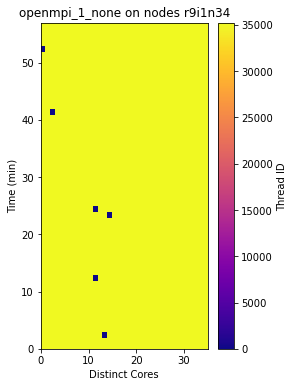

openmpi_1_rank on nodes r9i2n15
Threads running (by Thread ID) on each core:
0 [56924.]
1 [56925.]
2 [56926.]
3 [56927.]
4 [56928.]
5 [56929.]
6 [56930.]
7 [56931.]
8 [56932.]
9 [56933.]
10 [56934.]
11 [56935.]
12 [56936.]
13 [56937.]
14 [56938.]
15 [56939.]
16 [56940.]
17 [56941.]
18 [56942.]
19 [56943.]
20 [56944.]
21 [56945.]
22 [56946.]
23 [56947.]
24 [56948.]
25 [56949.]
26 [56950.]
27 [56951.]
28 [56952.]
29 [56953.]
30 [56954.]
31 [56955.]
32 [56956.]
33 [56957.]
34 [56958.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 35
Number of unique threads used during the run: 35
Number of cores handling multiple threads: 0
Number of threads processed on multiple cores: 0
Total number of tasks requested: 36
Total number of nodes requested: 1
Max number of threads processed by a single core: 1


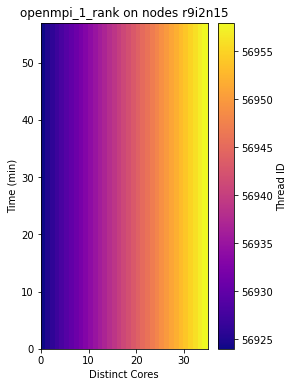

openmpi_2_cores on nodes r1i3n20 r1i4n5
Threads running (by Thread ID) on each core:
0 [191947.]
1 [191949.]
2 [191951.]
3 [191953.]
4 [191955.]
5 [191957.]
6 [191959.]
7 [191961.]
8 [191963.]
9 [191965.]
10 [191967.]
11 [191969.]
12 [191971.]
13 [191973.]
14 [191975.]
15 [191977.]
16 [191979.]
17 [191946.]
18 [191948.]
19 [191950.]
20 [191952.]
21 [191954.]
22 [191956.]
23 [191958.]
24 [191960.]
25 [191962.]
26 [191964.]
27 [191966.]
28 [191968.]
29 [191970.]
30 [191972.]
31 [191974.]
32 [191976.]
33 [191978.]
34 [191980.]
35 [144402.]
36 [144404.]
37 [144406.]
38 [144408.]
39 [144410.]
40 [144412.]
41 [144414.]
42 [144416.]
43 [144418.]
44 [144420.]
45 [144422.]
46 [144424.]
47 [144426.]
48 [144428.]
49 [144430.]
50 [144432.]
51 [144434.]
52 [144401.]
53 [144403.]
54 [144405.]
55 [144407.]
56 [144409.]
57 [144411.]
58 [144413.]
59 [144415.]
60 [144417.]
61 [144419.]
62 [144421.]
63 [144423.]
64 [144425.]
65 [144427.]
66 [144429.]
67 [144431.]
68 [144433.]
69 [144435.]
Threads running

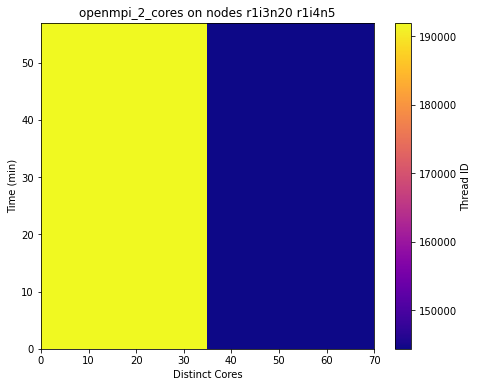

openmpi_4_cores on nodes r9i1n35 r9i2n20 r9i2n33 r9i5n1
Threads running (by Thread ID) on each core:
0 [49686.]
1 [49688.]
2 [49690.]
3 [49692.]
4 [49694.]
5 [49696.]
6 [49698.]
7 [49700.]
8 [49702.]
9 [49704.]
10 [49706.]
11 [49708.]
12 [49710.]
13 [49712.]
14 [49714.]
15 [49716.]
16 [49718.]
17 [49685.]
18 [49687.]
19 [49689.]
20 [49691.]
21 [49693.]
22 [49695.]
23 [49697.]
24 [49699.]
25 [49701.]
26 [49703.]
27 [49705.]
28 [49707.]
29 [49709.]
30 [49711.]
31 [49713.]
32 [49715.]
33 [49717.]
34 [49719.]
35 [45289.]
36 [45291.]
37 [45293.]
38 [45295.]
39 [45297.]
40 [45299.]
41 [45301.]
42 [45303.]
43 [45305.]
44 [45307.]
45 [45309.]
46 [45311.]
47 [45313.]
48 [45315.]
49 [45317.]
50 [45319.]
51 [45321.]
52 [45288. 45488.]
53 [45290.]
54 [45292.]
55 [45294.]
56 [45296.]
57 [45298.]
58 [45300.]
59 [45302.]
60 [45304.]
61 [45306.]
62 [45308.]
63 [45310.]
64 [45312.]
65 [45314.]
66 [45316.]
67 [45318.]
68 [45320.]
69 [45322.]
70 [35166.]
71 [35168.]
72 [35170.]
73 [35172.]
74 [35174.]
75

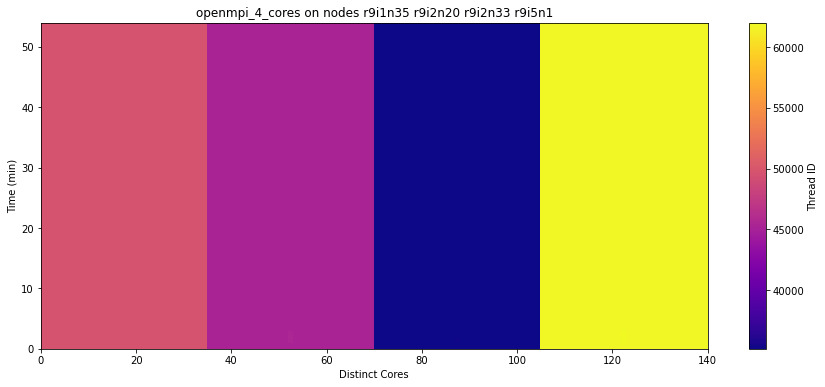

intel_4_none on nodes r10i0n2 r10i0n34 r10i1n0 r10i1n26
Threads running (by Thread ID) on each core:
0 [52696. 52720. 52721. 52726.]
1 [52700. 52717. 52720. 52721. 52726. 52728. 52730.]
2 [    0. 52696. 52700. 52710. 52720. 52728.]
3 [52696. 52706. 52716. 52721. 52729. 52731.]
4 [52700. 52717. 52720. 52721. 52729. 52731.]
5 [52705.]
6 [52696. 52704. 52710. 52716. 52720.]
7 [52716. 52720. 52726. 52731.]
8 [52706. 52717. 52720. 52729.]
9 [52696. 52700. 52726. 52729.]
10 [52711.]
11 [52725.]
12 [52700. 52701.]
13 [52699. 52704. 52717. 52729. 52730.]
14 [52704. 52708. 52728. 52731.]
15 [52708. 52710. 52726. 52728.]
16 [52707. 52728. 52729.]
17 [    0. 52698. 52701. 52706. 52707. 52708. 52709. 52710. 52712. 52713.
 52714. 52715. 52718. 52719. 52722. 52724. 52727.]
18 [52697. 52698. 52702. 52703. 52708. 52712. 52714. 52715. 52719.]
19 [    0. 52697. 52706. 52713. 52714. 52715. 52723.]
20 [52697. 52707. 52712. 52722. 52723. 52724.]
21 [52702. 52712. 52713. 52714. 52722. 52723.]
22 [52723. 527

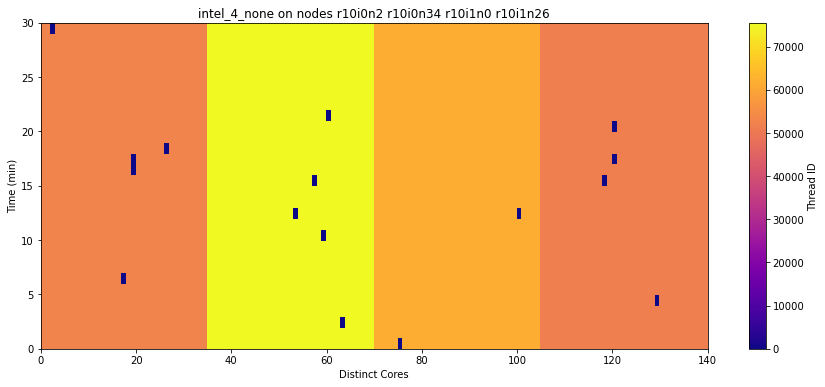

intel_4_rank on nodes r10i1n27 r10i1n29 r10i1n30 r10i1n31
Threads running (by Thread ID) on each core:
0 [53143.]
1 [53144.]
2 [53145.]
3 [53146.]
4 [53147.]
5 [53148.]
6 [53149.]
7 [53150.]
8 [53151.]
9 [53152.]
10 [53153.]
11 [53154.]
12 [53155.]
13 [53156.]
14 [53157.]
15 [53158.]
16 [53159.]
17 [53160.]
18 [53161.]
19 [53162.]
20 [53163.]
21 [53164.]
22 [53165.]
23 [53166.]
24 [53167.]
25 [53168.]
26 [53169.]
27 [53170.]
28 [53171.]
29 [53172.]
30 [53173.]
31 [53174.]
32 [53175.]
33 [53176.]
34 [53177.]
35 [47112.]
36 [47113.]
37 [47114.]
38 [47115.]
39 [47116.]
40 [47117.]
41 [47118.]
42 [47119.]
43 [47120.]
44 [47121.]
45 [47122.]
46 [47123.]
47 [47124.]
48 [47125.]
49 [47126.]
50 [47127.]
51 [47128.]
52 [47129.]
53 [47130.]
54 [47131.]
55 [47132.]
56 [47133.]
57 [47134.]
58 [47135.]
59 [47136.]
60 [47137.]
61 [47138.]
62 [47139.]
63 [47140.]
64 [47141.]
65 [47142.]
66 [47143.]
67 [47144.]
68 [47145.]
69 [47146.]
70 [48070.]
71 [48071.]
72 [48072.]
73 [48073.]
74 [48074.]
75 [480

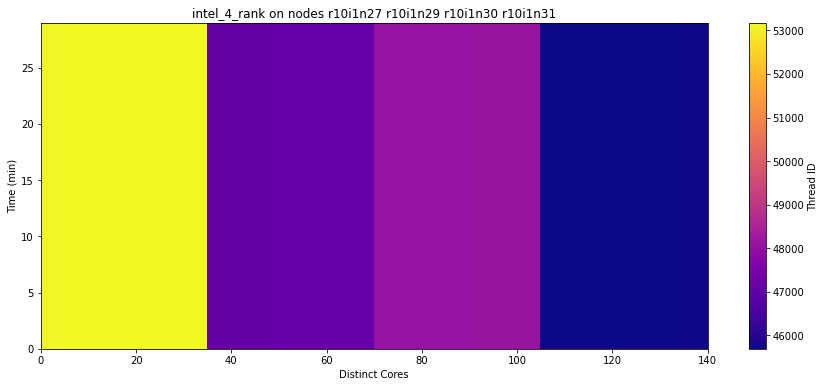

openmpi_1_cores on nodes r10i2n25
Threads running (by Thread ID) on each core:
0 [46358.]
1 [46360.]
2 [46362.]
3 [46364.]
4 [46366.]
5 [46368.]
6 [46370.]
7 [46372.]
8 [46374.]
9 [46376.]
10 [46378.]
11 [46380.]
12 [46382.]
13 [46384.]
14 [46386.]
15 [46388.]
16 [46390.]
17 [46357.]
18 [46359.]
19 [46361.]
20 [46363.]
21 [46365.]
22 [46367.]
23 [46369.]
24 [46371.]
25 [46373.]
26 [46375.]
27 [46377.]
28 [46379.]
29 [46381.]
30 [46383.]
31 [46385.]
32 [46387.]
33 [46389.]
34 [46391.]
Threads running on multiple cores (Thread ID, number of cores processed on)
Number of cores in use during the run: 35
Number of unique threads used during the run: 35
Number of cores handling multiple threads: 0
Number of threads processed on multiple cores: 0
Total number of tasks requested: 36
Total number of nodes requested: 1
Max number of threads processed by a single core: 1


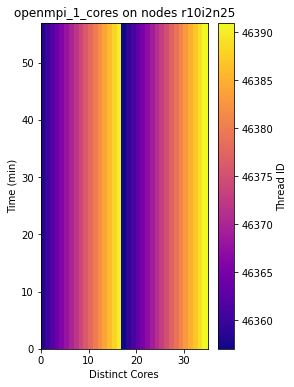

In [19]:
eagle_data_for_table = []

for file in eagle_onnodes:
    f = open('eagle/'+file, "r")
    data = f.readlines()
    data_array = []
    one_run = []
    node = data[0].strip()
    for i in range(1, len(data)):
        array_line = np.array(data[i].split())
        if "r" in array_line[0]:
            if len(one_run)>1:
                data_array.append(one_run)
            node = array_line[0]
            one_run = []
        else:   
            if len(array_line)>1:
                if array_line[3] == "vasp_std":
                    if float(array_line[4])>1:
                        info = [int(array_line[2]),float(array_line[1]),node]
                        one_run.append(info)
    if len(one_run)>1:
        data_array.append(one_run)
    nodelist = []
    for section in data_array:
        for row in section:
            nodelist.append(row[2])
    nodes = np.unique(nodelist)
    all_data = []
    max_core = 0
    for section in data_array:
        for row in section:
            if row[0] > max_core:
                max_core = row[0]
    for node in nodes:
        plot_data = []
        for section in data_array:
            if section[0][2]==node:
                plot_row = np.zeros(max_core)
                for row in section:
                    plot_row[row[0]-1] = row[1]
                plot_data.append(plot_row)
        if len(all_data)==0:
            all_data = plot_data
        else:
            all_data = np.concatenate((all_data,plot_data),axis=1)
    title = file + " on nodes"
    nodelist = ""
    for node in nodes:
        nodelist += " "
        nodelist += node
    title += nodelist
    nodelist_arr = nodelist.split()
    print(title)
    threads_used = []
    core_use_count = 0
    cores_w_multiple_threads = 0
    threads_on_multiple_cores = 0
    max_num_threads_on_core = 0
    print("Threads running (by Thread ID) on each core:")
    for i in range(len(all_data[1])):
        print(i, np.unique(np.array(all_data)[:,i]))
        num_threads_on_core = len(np.unique(np.array(all_data)[:,i]))
        if num_threads_on_core > max_num_threads_on_core:
            max_num_threads_on_core = num_threads_on_core
        thread_count = 0
        for j in np.unique(np.array(all_data)[:,i]):
            if j > 0:
                threads_used.append(j)
                thread_count += 1
        if len(np.unique(np.array(all_data)[:,i]))>0 and np.unique(np.array(all_data)[:,i])[-1]>0:
            core_use_count += 1
            if thread_count > 1:
                cores_w_multiple_threads += 1
    print("Threads running on multiple cores (Thread ID, number of cores processed on)")
    for i in np.unique(threads_used):
        num_cores_on = threads_used.count(i)
        if num_cores_on > 1:
            print(i, num_cores_on)
            threads_on_multiple_cores += 1
    print("Number of cores in use during the run:", core_use_count)
    print("Number of unique threads used during the run:", len(np.unique(threads_used)))
    print("Number of cores handling multiple threads:", cores_w_multiple_threads)
    print("Number of threads processed on multiple cores:", threads_on_multiple_cores)
    print("Total number of tasks requested:", len(nodelist_arr)*36)
    print("Total number of nodes requested:", len(nodelist_arr))
    print("Max number of threads processed by a single core:", max_num_threads_on_core)
    eagle_data_for_table.append([file, len(nodelist_arr)*36, len(nodelist_arr), core_use_count, len(np.unique(threads_used)), cores_w_multiple_threads, threads_on_multiple_cores, max_num_threads_on_core])
    locals()["swift_"+file] = all_data
    fig = plt.figure(figsize=(8*(len(all_data[0])/75),6))
    plot = plt.pcolormesh(all_data,cmap="plasma")
    cbar = plt.colorbar(plot)
    cbar.set_label("Thread ID")
    plt.title(title)
    plt.xlabel("Distinct Cores")
    plt.ylabel("Time (min)")
    plt.show()

In [20]:
col_names = ["Calculation Title (MPI, num nodes, cpu-bind)", "Total number of tasks requested", "Total number of nodes requested", "Number of cores in use during the run", "Number of unique threads used during the run", "Number of cores handling multiple threads", "Number of threads processed on multiple cores", "Max number of threads processed by a single core"]
eagle_data_table = pd.DataFrame(eagle_data_for_table, columns = col_names)
eagle_data_table.sort_values("Calculation Title (MPI, num nodes, cpu-bind)", inplace=True)
eagle_data_table

,"Calculation Title (MPI, num nodes, cpu-bind)",Total number of tasks requested,Total number of nodes requested,Number of cores in use during the run,Number of unique threads used during the run,Number of cores handling multiple threads,Number of threads processed on multiple cores,Max number of threads processed by a single core
2,intel_1_cores,36,1,35,35,0,0,1
4,intel_1_none,36,1,35,36,35,36,16
5,intel_1_rank,36,1,35,35,0,0,1
7,intel_2_cores,72,2,70,70,0,0,1
9,intel_2_none,72,2,70,65,70,65,23
10,intel_2_rank,72,2,70,70,0,0,1
3,intel_4_cores,144,4,140,140,0,0,1
15,intel_4_none,144,4,140,144,135,139,17
16,intel_4_rank,144,4,140,140,0,0,1
17,openmpi_1_cores,36,1,35,35,0,0,1


In [20]:
os.system("jupyter nbconvert --execute --to html cpu-bind_VASP.ipynb")

0